In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split as tts
from PIL import Image
import os
import tensorflow as tf
import multiprocessing as mp
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,recall_score,precision_score, f1_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.ensemble import IsolationForest
import Covid_Project_Functions as CPF
from joblib import dump
import neural_net_cross_val as nn_cross
from tensorflow.keras.models import save_model
import cropping_pipeline as Pipe
import random
import correlation_plots as CP

2024-07-25 04:30:11.523564: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Initital Processing of Images

In [2]:
def read_images(classes_paths):
    images=[]
    labels=[]
    fnames=[]
    
    for label,path in enumerate(classes_paths):
        for filename in sorted(os.listdir(path)): #Load in Xray images
            dir=os.path.join(os.getcwd(),path)
            image_path=os.path.join(dir,filename)
            image = tf.io.read_file(image_path)
            image = tf.io.decode_image(image, channels=1, expand_animations=False)
            images.append(image)
            labels.append(label)
            relative_path=os.path.join(path,filename)
            fnames.append(relative_path)
    return images,labels,fnames
def process_images(images,n):
    processed_images=[]
    for image in images:
        image = tf.image.resize(image, [n, n])
        image = tf.cast(image, tf.float32) / 255.0 #Standardize
        processed_images.append(image)
    
        image_tensor = tf.stack(processed_images)
        image_tensor = tf.reshape(image_tensor, (len(processed_images), n*n))
        image_tensor_array=image_tensor.numpy()
    return image_tensor_array


In [2]:
REGENERATE=False
if REGENERATE:
    paths=['Covid_Project/COVID-19 cases','Covid_Project/Pneumonia','Covid_Project/Normal ']
    images, labels, names=read_images(paths)
    processed_images=process_images(images,224)
    binary_labels=[int(lab==0) for lab in labels]
    df=CPF.to_DataFrame(processed_images,labels,binary_labels,names) # This data was saved to csv and sent to other group members to explore
else:
    df=pd.read_csv('covid_data3.csv')


In [3]:
features_224=[col for col in df.columns if col.startswith('feature')]
X,X_train,y_train,X_test,y_test,X_train_scaled,X_test_scaled,scaler=CPF.create_tts_from_df(df,features_224)

# Initial Logistic Regression Model

In [4]:
SAVE=False
lr=LogisticRegression(max_iter=1000)
lr.fit(X_train,y_train)
if SAVE:
    # Save the trained model to disk
    dump(lr, 'baseline_LogReg.joblib')
test_preds=lr.predict(X_test)

CPF.get_scores(y_test,test_preds,X_train,y_train,lr, 'lr_initial','Logistic_Regression') 
print()
CPF.print_confusion_matrix(y_test,test_preds)

Logistic_Regression Scores (test set)
	Accuracy Score: 0.9318181818181818
	Recall Score: 0.9318181818181818
	Precision Score: 0.9761904761904762
	f1_score: 0.9534883720930233

            Cross Validated Scores
|    |   Cross_Val_Accuracy |   Cross_Val_Recall |   Cross_Val_F1 |
|---:|---------------------:|-------------------:|---------------:|
|  0 |             0.958419 |           0.914603 |       0.941268 |


Confusion Matrix 
	True Negatives: 76
	False Positives: 1
	False Negatives: 3
	True Positive: 41


In [6]:
SAVE_SVM=False
SVM=SVC(probability=True)
SVM.fit(X_train_scaled,y_train)
if SAVE_SVM:
    dump(SVM, 'baseline_SVM.joblib')
test_preds_svm=SVM.predict(X_test_scaled)
CPF.get_scores(y_test,test_preds_svm,X_train,y_train,lr, 'svm_initial','Support Vector Machine',cross_val=False)
print()
CPF.print_confusion_matrix(y_test,test_preds_svm)

Support Vector Machine Scores (test set)
	Accuracy Score: 0.9545454545454546
	Recall Score: 0.9545454545454546
	Precision Score: 0.9333333333333333
	f1_score: 0.9438202247191012

            Cross Validated Scores
|    |   Cross_Val_Accuracy |   Cross_Val_Recall |   Cross_Val_F1 |
|---:|---------------------:|-------------------:|---------------:|
|  0 |             0.958419 |           0.914603 |       0.941268 |


Confusion Matrix 
	True Negatives: 74
	False Positives: 3
	False Negatives: 2
	True Positive: 42


# Initial Neural Network

In [7]:
def build_model():
    model_nn = Sequential([
                      Dense(units=64, activation='relu'),  # Input layer with feature size
                      Dense(units=32, activation='relu'),
                      Dense(units=1, activation='sigmoid')])
    model_nn.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy','recall'])
    
    return model_nn

In [8]:
SAVE_NN=False
model_nn=build_model()
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)
model_nn.fit(X_train_scaled,y_train,epochs=7,batch_size=32)
pred_probs=model_nn.predict(X_test_scaled) #Obtain probabilities for each test image
test_loss, test_accuracy,test_recall = model_nn.evaluate(X_test_scaled, y_test)
preds_nn=[int(pred>=0.5) for pred in pred_probs.reshape(-1,)]
print('Scores for Neural Network  (test set)') 
print("\tAccuracy", accuracy_score(y_test,preds_nn))
print("\tRecall",recall_score(y_test,preds_nn))
print("\tPrecision", precision_score(y_test,preds_nn))
print("\tF1_score", f1_score(y_test,preds_nn))
print()
nn_cross.neural_net_cross_val(X_train_scaled,y_train.to_numpy())
CPF.print_confusion_matrix(y_test, probabilities=pred_probs.reshape(-1,), title='Neural Network')
if SAVE_NN:
    model_nn.save('baseline_nn.keras')

Epoch 1/7
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7778 - loss: 1.7770 - recall: 0.9385
Epoch 2/7
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9553 - loss: 1.6858 - recall: 0.9367
Epoch 3/7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9680 - loss: 0.5293 - recall: 0.9485
Epoch 4/7
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9689 - loss: 0.9624 - recall: 0.9628
Epoch 5/7
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9823 - loss: 0.4034 - recall: 0.9538
Epoch 6/7
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9941 - loss: 0.0501 - recall: 1.0000
Epoch 7/7
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9770 - loss: 0.1668 - recall: 0.9583
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9298 - loss: 1.0291 - recall: 0.9775  
Scores for Neural Network  (test set)
	Accuracy 0.9338842975206612
	Recall 0.9772727272727273
	Precision 0.86
	F1_score 0.9148936170212766

	Cross Validated Accuracy

# Will the models really perform well on Unseen images

In [41]:
read_from_path=False
if read_from_path:
    test_paths=['Testing_Outside/COVID','Testing_Outside/Pneumonia','Testing_Outside/Normal']
    testing_images,testing_labels, testing_fnames=read_images(test_paths)
    testing_processed_images=process_images(testing_images,224)
    testing_binary_labels=[int(lab==0) for lab in testing_labels]
    df_outside=CPF.to_DataFrame(testing_processed_images,testing_labels,testing_binary_labels,testing_fnames)
else:
    df_outside=pd.read_csv('Outside_Testing_224.csv')
    


**Class labels of outside test set**

In [10]:
df_outside['label'].value_counts()

label
0    392
2    246
1    229
Name: count, dtype: int64

In [43]:
X_testing=df_outside[features_224]
y_testing=df_outside['binary_label']
test_preds_lr=lr.predict(X_testing)

def get_scores_two(y_test, test_preds,title):
    accuracy=accuracy_score(y_test,test_preds)
    recall=recall_score(y_test, test_preds)
    print()
    print(f'\tAccuracy Score: {accuracy}')
    print(f'\tRecall Score: {recall}')
    print(f'\tPrecision Score: {precision_score(y_test,test_preds)}')
    print(f'\tF1_Score: {f1_score(y_test,test_preds)}')
print('Logistic Regression on Outside Test Set')
get_scores_two(y_testing,test_preds_lr,'Logistic Regression')
test_preds_svm=SVM.predict(scaler.fit_transform(scaler.fit_transform(X_testing)))
print('\nSupport Vector Machine (Outside Test Set)')
get_scores_two(y_testing,test_preds_svm,'Support Vector Machine')
print('Logistic Regression Confusion Matrix')
CPF.print_confusion_matrix(y_testing,test_preds_lr)

Logistic Regression on Outside Test Set

	Accuracy Score: 0.6955017301038062
	Recall Score: 0.9030612244897959
	Precision Score: 0.6103448275862069
	F1_Score: 0.728395061728395

Support Vector Machine (Outside Test Set)

	Accuracy Score: 0.6897347174163783
	Recall Score: 0.6607142857142857
	Precision Score: 0.6556962025316456
	F1_Score: 0.6581956797966964
Logistic Regression Confusion Matrix

Confusion Matrix 
	True Negatives: 249
	False Positives: 226
	False Negatives: 38
	True Positive: 354


# Models perform well on training and test sets but do not perform well on other data gathered from outside sources.
**Possibly, there are non-medical elements in the images that are being identified by the models.   Since these elements are consistent beteween the test and training sets, the model still performs well on the test set.    Another possibility is that the data isn't diverse enough, perhaps the positive covid cases are the most severe cases and are easily identifiable.**

# Outlier Detection

In [5]:
# Outlier Detect Isolation Forest
clf=IsolationForest(random_state=42).fit(X)
forest_labels=clf.predict(X)
forest_outliers=[]
idxs=[]
for i, label in enumerate(forest_labels):
    if label==-1:
        row=df.iloc[i]
        forest_outliers.append(row['Image_Path'])
        idxs.append(i)


print(f'{len(idxs)} identified by Isolation Forest')
print('Outlier Indices')
print('\n',idxs)

Covid_Project/COVID-19 cases/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-002-fig3a.png
65 identified by Isolation Forest
Outlier Indices

 [0, 14, 17, 18, 20, 30, 32, 42, 47, 49, 54, 55, 62, 64, 67, 79, 80, 82, 83, 87, 96, 100, 101, 104, 105, 106, 107, 110, 113, 114, 115, 118, 119, 122, 123, 124, 133, 134, 137, 140, 148, 150, 153, 157, 159, 166, 177, 179, 181, 189, 191, 194, 198, 200, 205, 209, 210, 211, 212, 213, 223, 368, 397, 461, 465]


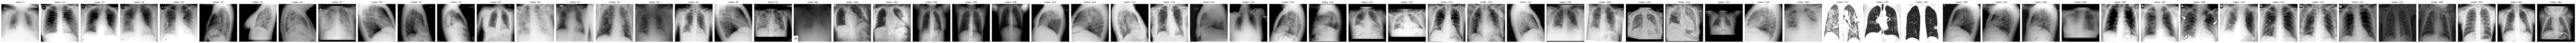

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_outlier_images(df, indices, image_shape=(256, 256)):

    features = [col for col in df.columns if col.startswith('feature')]
    images = df[features].values  # Get the image data as a numpy array


    num_images = len(indices)
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 8))

  
    for ax, idx in zip(axes, indices):
       
        image = images[idx].reshape(image_shape)

       
        image = (image * 255).astype(np.uint8)  # Ensure the image is in uint8 format

        
        ax.imshow(image, cmap='gray')  # Use 'gray' for grayscale images
        ax.axis('off')  # Hide axes
        ax.set_title(f'Index: {idx}')  

    plt.tight_layout()
    plt.show()

outlier_indices = [0, 5, 10]  
plot_outlier_images(df, idxs,image_shape=(224, 224))

side_angle=[30,32,42,49,54,55,83,107,110,113,115,119,122,137,159,189,191,194]

#You should be able to click on the images to enhance them

 **I used a conservative parameter for the isolation forest which gave me a lot of outliers.  I visually inspected them to determine if any should be removed.**

Plots of Outliers


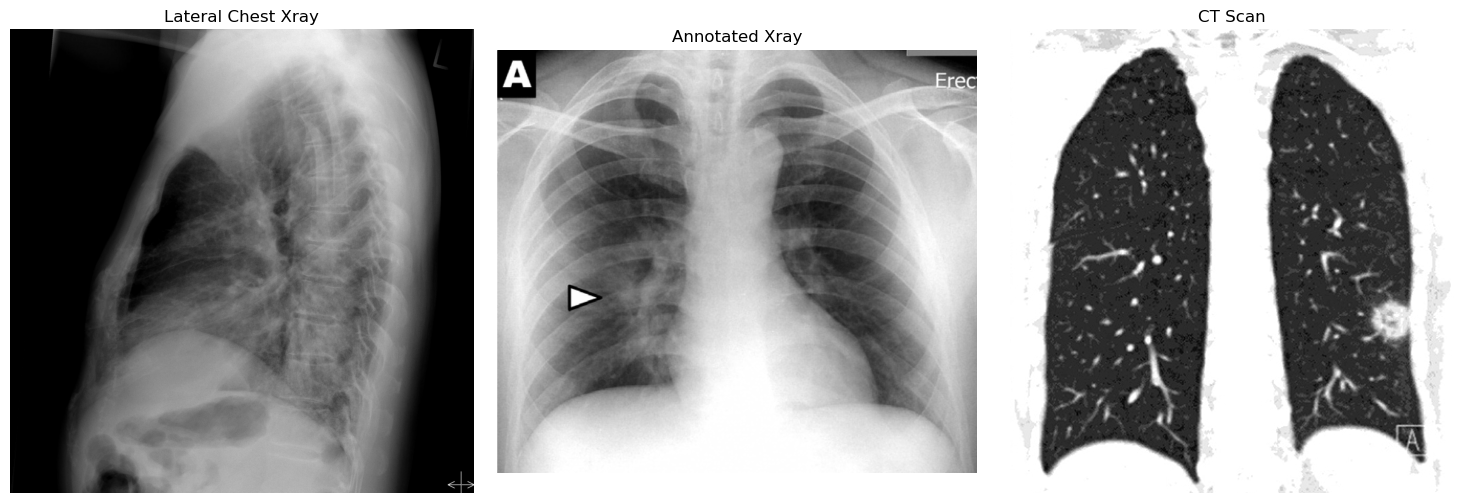

In [16]:
import plot_images as P
print('Plots of Outliers')
title1='Lateral Chest Xray'
title2='Annotated Xray'
title3='CT Scan'
P.display_three_images(df.iloc[30]['Image_Path'], df.iloc[205]['Image_Path'], df.iloc[181]['Image_Path'], title1, title2, title3, figsize=(15, 5))


 **The visual inspection reveals that there are three types of outliers that stand out as potentially being a problem.  There are CT scans, lateral xrays, and images that have radiologist annotations on them.  These become particularly problematic when you realize that they all belong to the positive class.  All of these types of outliers are examples of covid-19 cases in the data set.**

# Distributions of side angle images compared to all other non-outlier images.

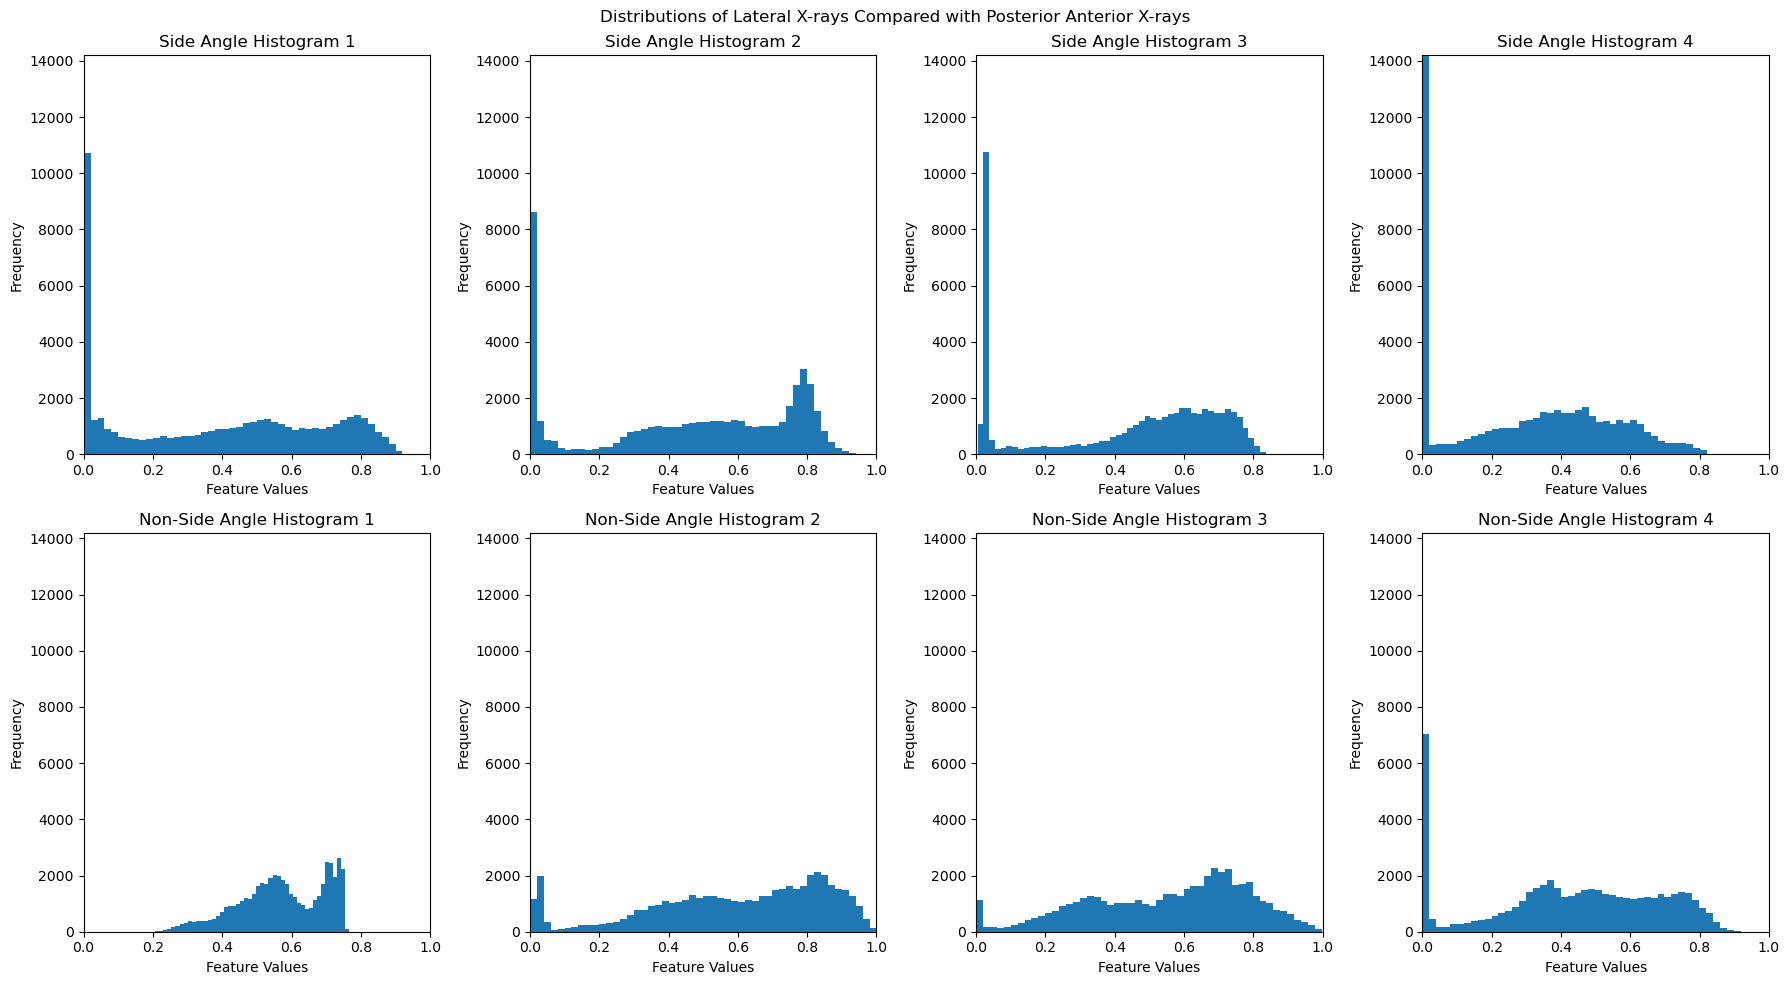

In [6]:
fig, axs = plt.subplots(2, 4, figsize=(18, 10))

axs = axs.flatten()

x_min, x_max = float('inf'), float('-inf')
y_max = 0

for i in range(4):
    hist_data = df.iloc[random.choice(side_angle)][features_224]
    hist, bins, _ = axs[i].hist(hist_data, bins=50)
    axs[i].set_title(f'Side Angle Histogram {i+1}')
    axs[i].set_xlabel('Feature Values')
    axs[i].set_ylabel('Frequency')
    x_min = min(x_min, bins.min())
    x_max = max(x_max, bins.max())
    y_max = max(y_max, hist.max())

for i in range(4, 8):
    hist_data = df[~df.index.isin(idxs)].iloc[random.randint(0, len(df)-len(idxs))][features_224]
    hist, bins, _ = axs[i].hist(hist_data, bins=50)
    axs[i].set_title(f'Non-Side Angle Histogram {i-3}')
    axs[i].set_xlabel('Feature Values')
    axs[i].set_ylabel('Frequency')
    x_min = min(x_min, bins.min())
    x_max = max(x_max, bins.max())
    y_max = max(y_max, hist.max())

for ax in axs:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, y_max)

plt.suptitle('Distributions of Lateral X-rays Compared with Posterior Anterior X-rays')
plt.tight_layout()
plt.show()

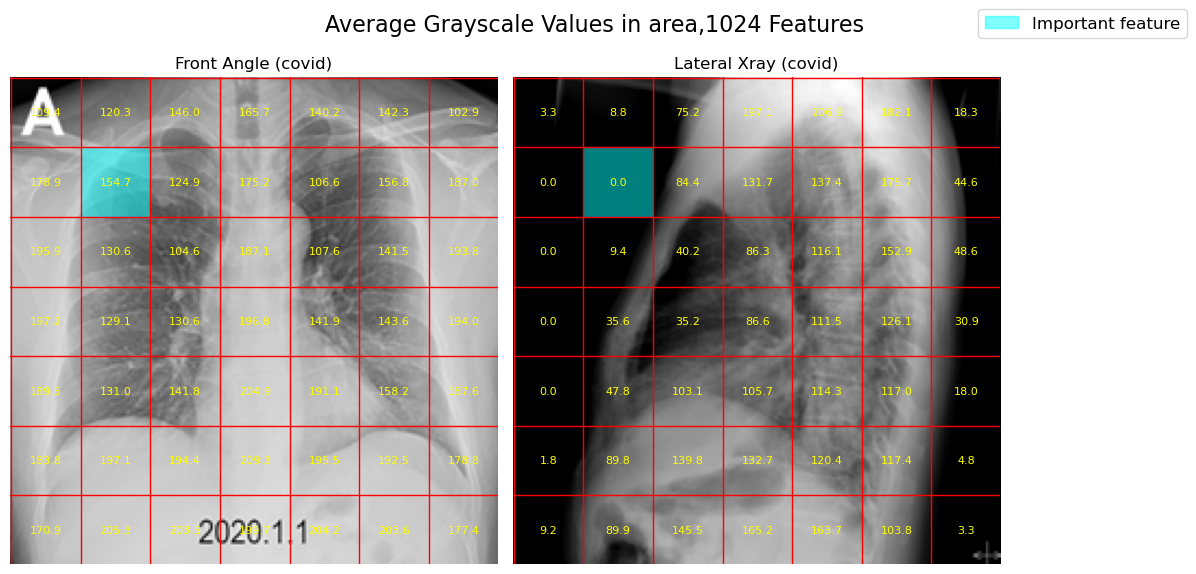

In [9]:
image_path2 = df.iloc[30]['Image_Path']
image_path1 = df.iloc[186]['Image_Path']
CP.display_image_grid(image_path1, image_path2, title2='Lateral Xray (covid)',title1='Front Angle (covid)', block_size=32, highlight_row=1, highlight_col=1)



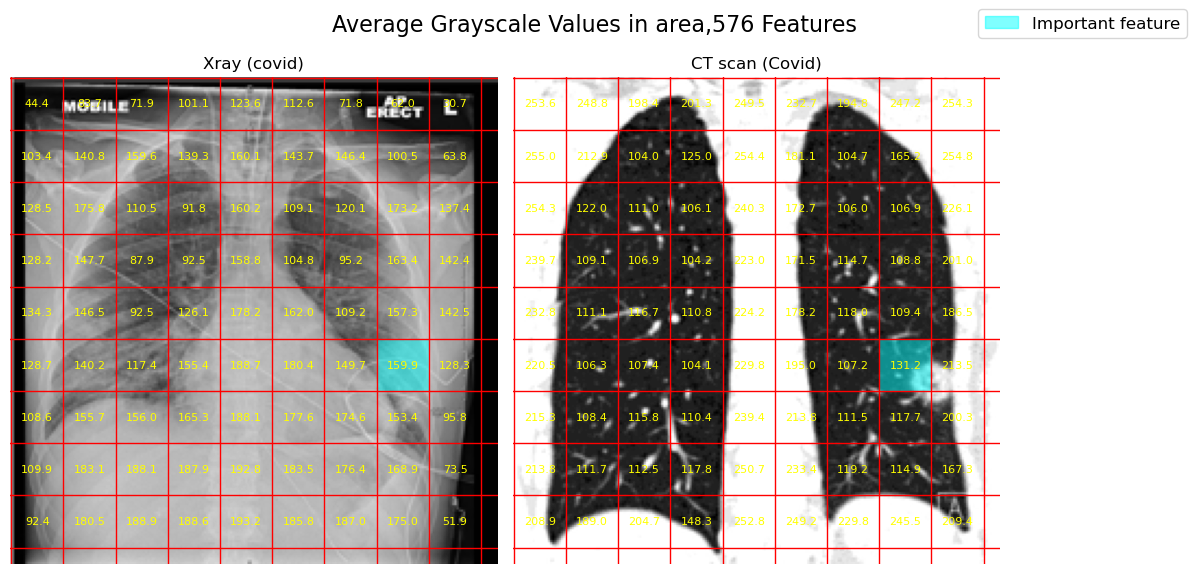

In [16]:
image_path2 = df.iloc[181]['Image_Path']
image_path1 = df.iloc[169]['Image_Path']
CP.display_image_grid(image_path1, image_path2, title2='CT scan (Covid)',title1='Xray (covid)', block_size=24, highlight_row=5, highlight_col=7)


**The highlighted blue area in both plots represents areas that are expected to be important to the diagnosis of covid-19 pneumonia. The intention is to show that in the values in this region, with respect to the ct scans and lateral xrays, will fall outside of the expected range associated with a covid-19 patient.  We want the models to understand the true range of possible values associated with the disease.  Keeping these images in the training data would make the model associate a positive label with values that are actually outside of this true range.**

# Remove Outliers

In [28]:
import pickle
chosen_outliers=[132,137,17,155,30,159,32,166,42,170,171,176,49,177,179,178,181,54,55,180,188,189,190,191,193,194,204,205,208,210,209,83,211,93,107,108,110,113,115,119,122]
with open('original_outliers.pkl', 'rb') as file:
    # Load the contents of the file and assign to a variable
    relative_outlier_paths = pickle.load(file)
outlier_paths=[os.path.join(os.getcwd(),path) for path in relative_outlier_paths]


In [29]:
RUN=False
import neural_net_cross_val as nn_cross
df_removed=df[~df["Image_Path"].isin(relative_outlier_paths)]
print('Data Set size after removal', len(df_removed))
train_removed,test_removed=tts(df_removed,stratify=df_removed['binary_label'], test_size=0.2,random_state=3)
X_train_removed=train_removed[features_224]
y_train_removed=train_removed['binary_label']
X_test_removed=test_removed[features_224]
y_test_removed=test_removed['binary_label']

lr_removed=LogisticRegression(max_iter=1000)
lr_removed.fit(X_train_removed,y_train_removed)
preds_removed_lr=lr_removed.predict(X_test_removed)
print('\nLogistic Regression (test set)')
print('\tAccuracy Score after the removal of outliers (Logistic Regression):', accuracy_score(y_test_removed, preds_removed_lr))
print('\tRecall Score after the removal of outliers (Logistic Regression):', recall_score(y_test_removed, preds_removed_lr))
SVM_removed=SVC(probability=True)
print()
if RUN:
    print('\tCross Validated Accuracy Score:', cross_val_score(lr_removed,X_train_removed,y_train_removed,cv=5).mean())
    print('\tCross Validated Recall Score:', cross_val_score(lr_removed,X_train_removed,y_train_removed,cv=5,scoring='recall').mean())
print('\nSupport Vector Machine (test set)')
scaler=StandardScaler()
SVM_removed.fit(scaler.fit_transform(X_train_removed),y_train_removed)
preds_svm_removed=SVM_removed.predict(scaler.fit_transform(X_test_removed))
print('\tAccuracy Score after the removal of outliers (SVC):', accuracy_score(y_test_removed, preds_svm_removed))
print('\tRecall Score after the removal of outliers (SVC):', recall_score(y_test_removed, preds_svm_removed))
if RUN:
    print('\tCross Validated Accuracy Score:', cross_val_score(SVM_removed,scaler.fit_transform(X_train_removed),y_train_removed,cv=5).mean())
    print('\tCross Validated Recall Score',cross_val_score(SVM_removed,scaler.fit_transform(X_train_removed),y_train_removed,cv=5).mean())


model_after_rmv=build_model()
model_after_rmv.fit(scaler.fit_transform(X_train_removed),y_train_removed,epochs=7, batch_size=32)
nn2_loss,nn2_acc,nn2_recall=model_after_rmv.evaluate(scaler.fit_transform(X_test_removed),y_test_removed)
print('Neural Network scores (test set)')
print(f'\tAccuracy: {nn2_acc}\n\tRecall: {nn2_recall}')
print()
nn_cross.neural_net_cross_val(scaler.fit_transform(X_train_removed),y_train_removed.to_numpy())

Data Set size after removal 562

Logistic Regression (test set)
	Accuracy Score after the removal of outliers (Logistic Regression): 0.9646017699115044
	Recall Score after the removal of outliers (Logistic Regression): 0.9444444444444444


Support Vector Machine (test set)
	Accuracy Score after the removal of outliers (SVC): 0.9734513274336283
	Recall Score after the removal of outliers (SVC): 0.9722222222222222
Epoch 1/7
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7913 - loss: 1.9487 - recall: 0.9249
Epoch 2/7
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9699 - loss: 0.4374 - recall: 0.9501
Epoch 3/7
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9808 - loss: 0.2463 - recall: 0.9930
Epoch 4/7
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9964 - loss: 0.0121 - recall: 0.9950
Epoch 5/7
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9932 - loss: 0.0974 - recall: 0.9846
Epoch 6/7
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9677 - loss: 0.

In [18]:
SAVE_SVM_removed=False
if SAVE_SVM_removed:
    dump(SVM_removed, 'SVM_Pipeline2.joblib')


**Removing outliers does enhances performance on our own test sets.**

# Look at some of the images that were misclassified by the Logistic Regression Model

In [30]:
test_removed['preds_lr']=preds_removed_lr
false_negs=test_removed[(test_removed['binary_label'] == True) & (test_removed['preds_lr'] == False)]
false_pos=test_removed[(test_removed['binary_label'] == False) & (test_removed['preds_lr'] ==True)]


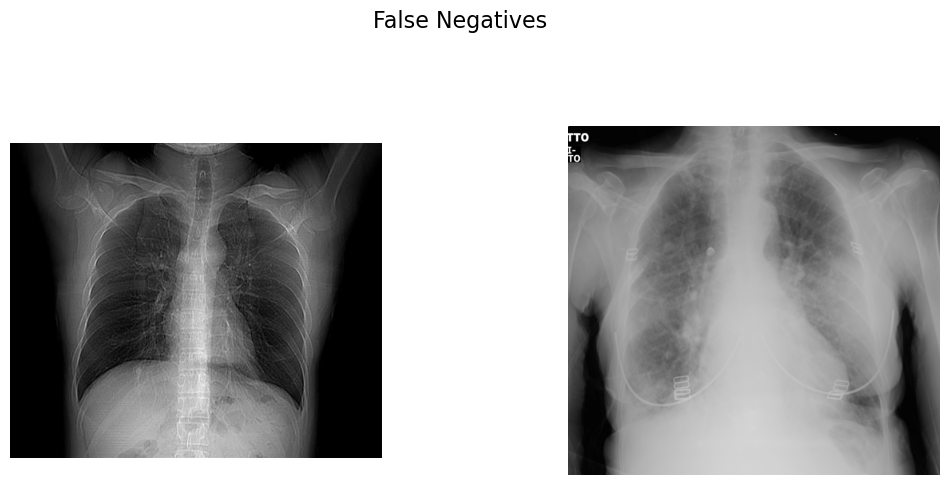

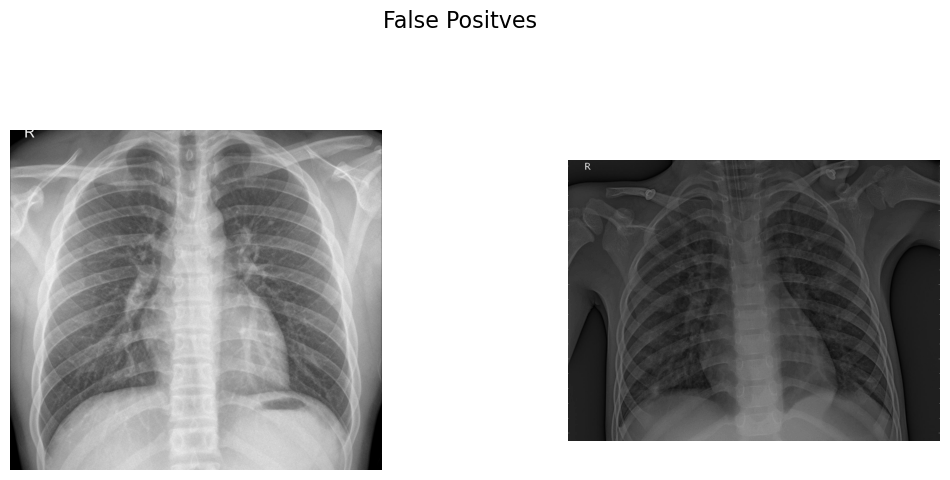

In [32]:
import matplotlib.pyplot as plt
from PIL import Image
def display_misses(image_path1, image_path2,title):  #this function is in plotting module.
  
    image1 = Image.open(image_path1)

    image2 = Image.open(image_path2)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(image1,cmap='gray')
    ax1.axis('off')

    ax2.imshow(image2,cmap='gray')
    ax2.axis('off')

    fig.suptitle(title, fontsize=16)

    plt.subplots_adjust(wspace=0.5)

    plt.show()
fns=false_negs['Image_Path'].values
fps=false_pos['Image_Path'].values

try:
    display_misses(fns[0], fns[1],'False Negatives')
except:
    print('There is Less than two False Negatives')
try:
    display_misses(fps[0], fps[1],'False Positves')
except:
    print('There is less than two False Positives')

# Correctly Classified Cases of Covid-19 (Logistic Regression Model)

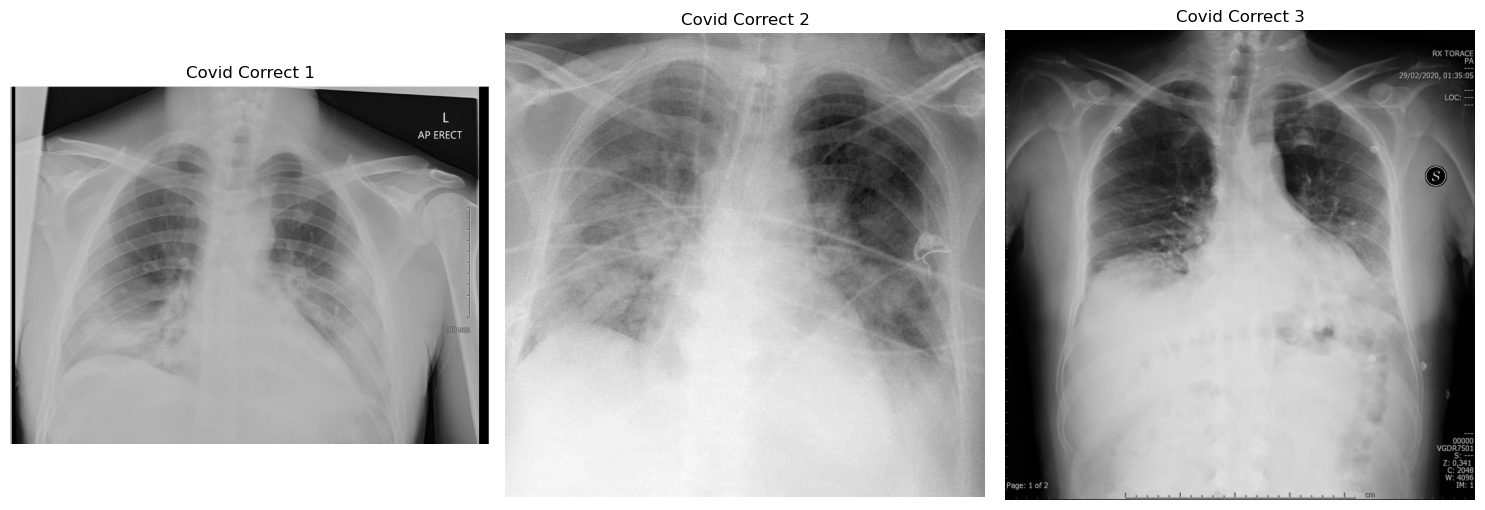

In [33]:
prediction_col='preds_lr'
correct = test_removed[(test_removed['binary_label'] == True) & (test_removed[prediction_col] == True)]
correct_ims=correct['Image_Path'].values

correct1=correct_ims[1]
correct2=correct_ims[2]
correct3=correct_ims[3]
D = {0: 'Covid', 1: 'Pneumonia', 2: 'Normal'}
P.display_three_images(correct1,correct2,correct3,'Covid Correct 1','Covid Correct 2','Covid Correct 3')

# Noticing other imbalances in the data set
**Upon further inspection, we noticed that images with certain charateristics are inconsistent across the two classes.  For example, All of the female x-rays are covid cases.  Furthermore, most of the x-rays where there is medical equipment present are covid cases. Such inconsistencies are of concern when trying to build a reliable model, and could explain why the models are not generalizing well to outside data.  We decided to keep examples of female/medical equipment x-rays, in the interest of not running out of data.**

# Cropping Images To the Lungs

In [34]:
import cropping_pipeline as Pipe
REGENERATE=False
if REGENERATE:
    paths=['Covid_Project/COVID-19 cases', 'Covid_Project/Pneumonia', 'Covid_Project/Normal ']
    resized_images_array, labels_cropped,path_to_file=Pipe.get_cropped_images(paths,outlier_paths=outlier_paths)
    binary_labels_cropped=[int(lab==0) for lab in labels_cropped]
    df_cropped=CPF.to_DataFrame(resized_images_array,labels_cropped,binary_labels_cropped,path_to_file)
    df_cropped.to_csv('covid_data_cropped_cleaned.csv')
else:
    df_cropped=pd.read_csv('covid_data_cropped_cleaned.csv')
unnamed_columns = [col for col in df_cropped.columns if 'Unnamed' in col]
df_croppped = df_cropped.drop(unnamed_columns, axis=1)

# Logistic Regression After Cropping

**Original Test Set**

In [36]:
features=[col for col in df_cropped.columns if col.startswith('feature')]
X_cropped,X_train_cropped,y_train_cropped,X_test_cropped,y_test_cropped,X_train_scaled_cropped,X_test_scaled_cropped,scaler_cropped=CPF.create_tts_from_df(df_cropped,features)

In [37]:
lr_cropped=LogisticRegression(max_iter=1000)
lr_cropped.fit(X_train_cropped,y_train_cropped)
preds_after_crop_lr=lr_cropped.predict(X_test_cropped)
get_scores_two(y_test_cropped,preds_after_crop_lr,title='Logistic Regression After Cropping')
CPF.print_confusion_matrix(y_test_cropped,preds_after_crop_lr)


	Accuracy Score: 0.9469026548672567
	Recall Score: 0.8888888888888888
	Precision Score: 0.9411764705882353
	F1_Score: 0.9142857142857143

Confusion Matrix 
	True Negatives: 75
	False Positives: 2
	False Negatives: 4
	True Positive: 32


**Outside Test set**

In [38]:
test_paths=['Testing_Outside/COVID','Testing_Outside/Pneumonia','Testing_Outside/Normal']
testing_images_cropped,testing_labels_cropped,testing_fnames_cropped=Pipe.get_cropped_images(test_paths)

Testing_Outside/COVID/Covid80.jpg


In [39]:
print('Peformance of Logistic Regression After Cropping')
testing_binary_labels_cropped=[int(lab==0) for lab in testing_labels_cropped]
outside_cropped_preds=lr_cropped.predict(testing_images_cropped)
get_scores_two(testing_binary_labels_cropped,outside_cropped_preds,'Outside Test Set Predictions after Cropping')
print()
CPF.print_confusion_matrix(testing_binary_labels_cropped,outside_cropped_preds)


Peformance of Logistic Regression After Cropping


/Users/bcsstaff/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



	Accuracy Score: 0.7093425605536332
	Recall Score: 0.8954081632653061
	Precision Score: 0.6245551601423488
	F1_Score: 0.7358490566037736


Confusion Matrix 
	True Negatives: 264
	False Positives: 211
	False Negatives: 41
	True Positive: 351


**Cropping the image does have the affect of reducing false positives (roughly 15 less), but also slightly increases the occurence of false negatives (3).  The result is a slightly better f1-score**

# Correlation Analysis
**To see what features a logistic regression model might treat as important, let's take a look at some correlation coefficients.   Linear correlation coefficients will be a good gauge for what a Logistic Regression might be treating as important features.   I will take a look at correlation coefficients at three different stages.**
* **Stage 1-Original Data**
* **Stage 2-Data after outlier removal**
* **Stage 3- After cropping the data**

**&emsp;Note that each heatmap shows the top 5000 correlation coefficients (absolute value) plotted in the general area of where the feature is located.**

# Original Data

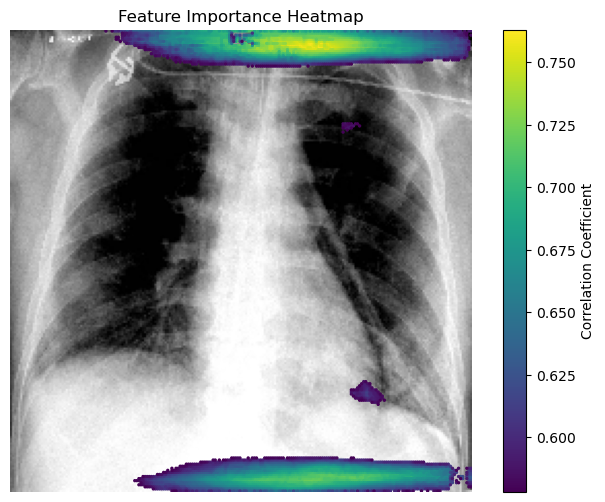

In [46]:
import correlation_plots as CP
CP.plot_feature_importance_heatmap_from_df(df, 'binary_label',image_size=224,image_index=200)

 **Most of the highly correlated features are in areas not associated with the the presence of covid-19.  This indicates that the models which assume linearity, may be using the wrong featues to make predictions.**

# After outlier removal

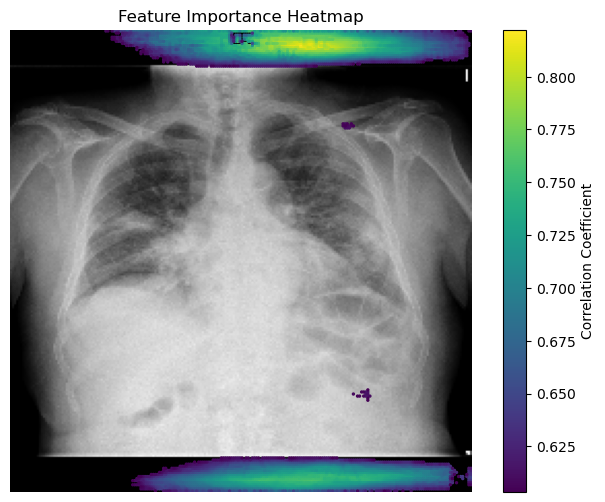

In [47]:
CP.plot_feature_importance_heatmap_from_df(df_removed, 'binary_label',image_size=224,image_index=107)

**After removing outliers there are less coefficents associated with areas near the heart and diaphram.  There is still a large number of correlation coefficients associated with the bottom and top of the image (outside the lungs).**

# After Cropping

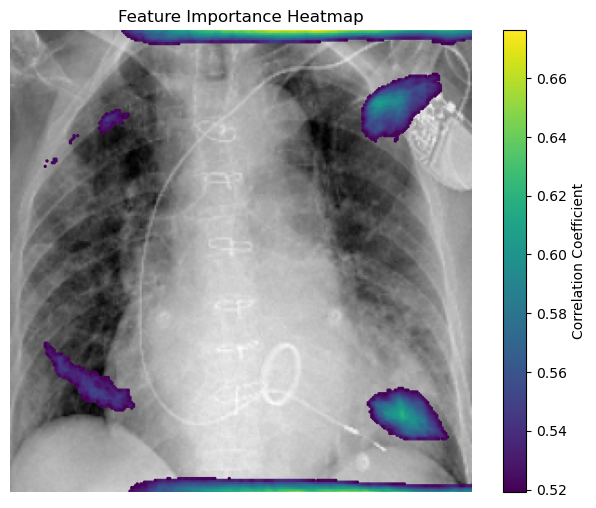

In [48]:
CP.plot_feature_importance_heatmap_from_df(df_cropped, 'binary_label',image_size=256,image_index=99)

**We see that cropping the images makes the high correlation coefficients be in areas that are in the lungs.  In particular, it seems like covid-19 is more related to the basilar and upper peripheral regions of the chest.  Note that the cropping didn't completely eliminate the existence of high correlation coefficients in irrelevant areas.**


# What areas are associated with non-covid Pneumonia?
**This is a covid-19 image but the correlation coefficents are for non-covid pneumonia.  You can definitely see the opacities in the left basilar area, The heatmap shows where these opacities might be if this was a patient who had pneumonia that was not caused by covid-19.**

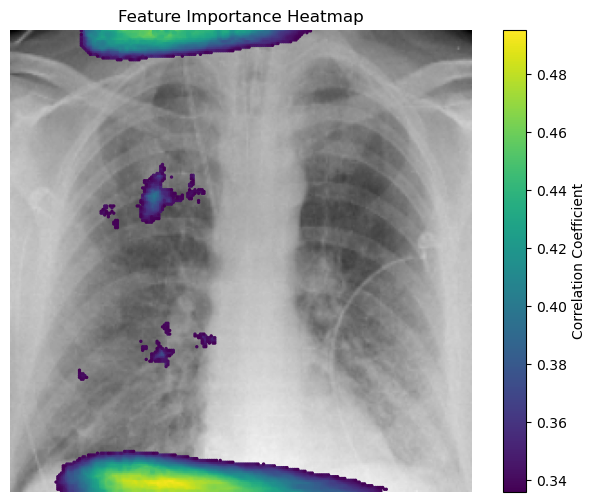

In [49]:
df_cropped['pneumonia']=(df_cropped['label']==1).astype(int)
CP.plot_feature_importance_heatmap_from_df(df_cropped,'pneumonia',image_size=256,image_index=177)

**Interestingly we see that pneumonia is more associated with the inner regions of the chest.  Also interesting to note is that highly correlated areas are only showing up on the right side of the chest.  This could potentially be because the heart is partially in the way on the left side.**

# Remove Irrelevant Features

**Because we are seeing unimportant features with high correlation coefficients, I decided to remove features from the periphery of the image.  This is basically further cropping the image to remove more of the diaphram and neck.*  I removed roughly 15,000 features from the top, bottom, left, and right of the image**

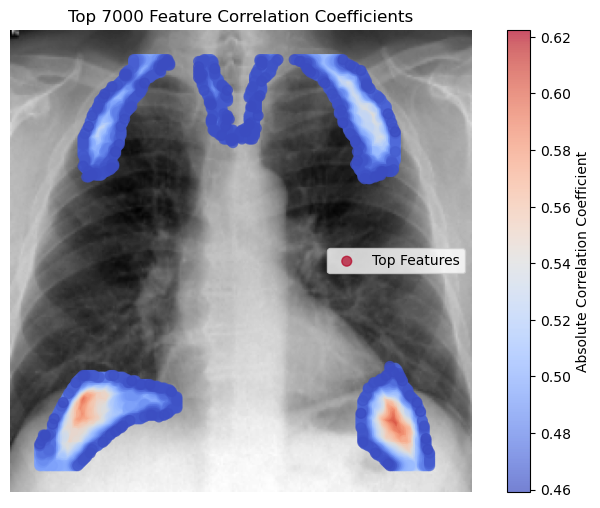

In [50]:
#Here Here Here do not remove this
import Feature_Removal as RF
# Combine removed features
df_cropped_copy=df_cropped.copy()
removed_features = set(
    RF.features_on_the_top(top_n=16) + 
    RF.features_on_bottom(bottom_n=14) + 
    RF.left_most_features(left_n=16) + 
    RF.right_most_features(right_n=16)
)

# Drop the removed features from the DataFrame
df_cropped_copy = df_cropped_copy.drop(columns=removed_features)

# Calculate correlation coefficients with the 'binary_label'
features = [col for col in df_cropped_copy.columns if col.startswith('feature')]
corr_with_label = df_cropped_copy[features].apply(lambda x: x.corr(df_cropped_copy['binary_label']))

# Sort the absolute correlation values
sorted_corr = corr_with_label.abs().sort_values(ascending=False)

# Select the top 7000 features based on correlation
top_n = 7000
top_features = sorted_corr.iloc[:top_n]

# Get the feature names and their pixel coordinates
feature_names = top_features.index
coords = [RF.get_pixel_coordinates(feature) for feature in feature_names]

# Extract the first feature image (assuming it's stored as a flattened array)
X_image = df_cropped[[col for col in df_cropped.columns if col.startswith('feature')]].values[8]

# Unnormalize the image data (assuming it was normalized to [0, 1])
X_image = X_image * 255  # Scale back to [0, 255]
X_image = X_image.astype(np.uint8)

# Reshape the image data to the correct dimensions (assuming 256x256)
image_shape = (256, 256)  # Adjust this based on your actual image dimensions
X_image = X_image.reshape(image_shape)

# Separate x and y coordinates
x_coords = [coord[1] for coord in coords]  # Column indices
y_coords = [coord[0] for coord in coords]  # Row indices

# Get the absolute correlation values for the top features
corr_values = [abs(corr_with_label[feature]) for feature in feature_names]

# Plot the image
plt.figure(figsize=(9, 6))
plt.imshow(X_image, cmap='gray')  # Display the image in grayscale

# Overlay the coordinates of the top features with absolute correlation values
sc = plt.scatter(x_coords, y_coords, c=corr_values, cmap='coolwarm', s=50, alpha=0.7, label='Top Features')
plt.colorbar(sc, label='Absolute Correlation Coefficient')
plt.title('Top 7000 Feature Correlation Coefficients')
plt.axis('off')  # Turn off axis
plt.legend()
plt.show()

# Image Augmentaion
**Because of the symmetries seen in the correlation coeffients across a vertical line I decided to add horizontally flipped versions of each image to the training data.  I also added slightly rotated versions of the image to the data.  Images were rotated and flipped at random, meaning either a flipped/rotated image was added, or the original image was added.  This form of augmentation was unsuccesful and did not help train the model towards higher performance.  I found that vertically flipped was most succesfull in improving the models performance on the outside test set.  The data was split into training and test sets and vertically flipped versions of each training image were added to the training set.  The decision was made to flip every image, not random flips.  All of this is an attempt to increase the variability of the correlated features, helping the models understand the possible values associated with the features.  For example, if a patient is showing signs of covid-19 in the top right periphery, the model would also get an example where the values associated with this regioin are also in the bottom right periphery.  In essence, we want to show the model the full range of possible values associated with the correlated features.**

**Crop the images in all sets in the same fashion and augment the training data with vertical flips**

In [51]:
RESAVE=False
RERUN=False
if RERUN:
    test_paths=['Testing_Outside/COVID','Testing_Outside/Pneumonia','Testing_Outside/Normal']
    testing_images_cropped,testing_labels_cropped,testing_fnames_cropped=Pipe.get_cropped_images(test_paths)
    testing_binary_labels_cropped=[int(lab==0) for lab in testing_labels_cropped]
    df_outside_cropped=CPF.to_DataFrame(testing_images_cropped,testing_labels_cropped,testing_binary_labels_cropped,testing_fnames_cropped)
    full_path=os.path.join(os.getcwd(),'csv','Outside_test_set_cropped.csv')
    df_outside_cropped.to_csv(full_path, index=False)
    df_outside_cropped=df_outside_cropped.drop(columns=removed_features)
    df_outside_cropped.to_csv('Outside_Test_Set_Cropped_Reduced_Augmented.csv')
else:
    df_outside_cropped=pd.read_csv('Outside_Test_Set_Cropped_Reduced_Augmented.csv') #Features already removed



Testing_Outside/COVID/Covid80.jpg


In [52]:
import image_augmentation as IG
REGENERATE=False
if REGENERATE:
    paths=['Covid_Project/COVID-19 cases','Covid_Project/Pneumonia','Covid_Project/Normal ']
    train_df,test_df=IG.apply_augmentation(paths,256,outlier_paths=outlier_paths,vertical_flip=True)
    train_df=train_df.drop(columns=removed_features)
    test_df=test_df.drop(columns=removed_features)
else:
    train_df=pd.read_csv('covid_data_augmented_train.csv')
    test_df=pd.read_csv('covid_data_test.csv')
    train_df=train_df.drop(columns=removed_features)
    test_df=test_df.drop(columns=removed_features)



# Description of Baseline
**Since the outside data set has more images in it, we will use it to gauge how our models are improving or not as we fine tune our models.  We will also monitor performance on our original test set**


### Overall goal:  Reduce the amount of false positives on the larger test set while maintaining good scores on the smaller test set.  Our baseline for success is seen below.  It only shows a logistic regression model, but all other models are comparable to these results.  We will closely monitor all of the scores and particularly the f1_score, in an attempt to reduce false postives on the larger test set.

In [53]:
print('Baseline Model Scores for Outside Testing data set (Logistic Regression Only)')
get_scores_two(testing_binary_labels_cropped,outside_cropped_preds,'Outside Test Set Predictions after Cropping')
print()
print('Baseline Model Scores for original test set (Logistic Regression Only)')
get_scores_two(y_test_cropped,preds_after_crop_lr,title='Logistic Regression After Cropping')


Baseline Model Scores for Outside Testing data set (Logistic Regression Only)

	Accuracy Score: 0.7093425605536332
	Recall Score: 0.8954081632653061
	Precision Score: 0.6245551601423488
	F1_Score: 0.7358490566037736

Baseline Model Scores for original test set (Logistic Regression Only)

	Accuracy Score: 0.9469026548672567
	Recall Score: 0.8888888888888888
	Precision Score: 0.9411764705882353
	F1_Score: 0.9142857142857143


# At this point the data was passed off for further analysis and model Tuning.

# COVID-19 Detection in Chest X-Ray Images

The goal of this project is to build a model that identifies COVID-19, pneumonia in chest X-Ray images. The dataset is organized into 3 folders (COVID-19 cases, Normal , Pneumonia) and contains subfolders for each image category. There are 606 X-Ray images (JPEG). Data from Mendeley.

In [35]:
# ! pip install scikeras

In [54]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split as tts
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.metrics import F1Score, Precision, Recall
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, LSTM, Dense, TimeDistributed, Dropout, BatchNormalization, concatenate, Layer
from scikeras.wrappers import KerasClassifier
import scipy
import os
import math
from statistics import mean
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [55]:
current_path = os.getcwd()

# 1. Orignial data(224 * 224): [1 : Covid as positive; 0 : normal + Pneumonia ]

In [56]:
covid_data = pd.read_csv(current_path + '/csv/covid_data2.csv')
covid_data.sample(6)

feature0  feature1  feature2  feature3  feature4  feature5  feature6  \
132  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
465  0.027451  0.047059  0.054902  0.070588  0.078431  0.094118  0.113725   
315  0.070588  0.082353  0.082353  0.078431  0.078431  0.078431  0.078431   
153  0.000000  0.000000  0.054902  0.149020  0.141176  0.137255  0.133333   
152  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
204  0.101961  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

     feature7  feature8  feature9  ...  feature50169  feature50170  \
132  0.000000  0.000000  0.000000  ...      0.294118      0.278431   
465  0.145098  0.184314  0.215686  ...      0.007843      0.011765   
315  0.078431  0.078431  0.078431  ...      0.078431      0.078431   
153  0.145098  0.141176  0.152941  ...      0.000000      0.000000   
152  0.000000  0.000000  0.000000  ...      0.619608      0.631373   
204  0.000000  0.000000  0.000000  ...      0.607843      0.619608   

     feature50171  feature50172  feature50173  feature50174  feature50175  \
132      0.235294      0.176471      0.149020      0.129412      0.105882   
465      0.011765      0.011765      0.011765      0.011765      0.011765   
315      0.078431      0.078431      0.078431      0.078431      0.078431   
153      0.000000      0.000000      0.000000      0.000000      0.000000   
152      0.635294      0.631373      0.521569      0.356863      0.325490   
204      0.588235      0.568627      0.537255      0.509804      0.454902   

     label  binary_label                                         Image_Path  
132      0          True  Covid_Project/COVID-19 cases/covid-19-pneumoni...  
465      2         False  Covid_Project/Pneumonia/person1616_virus_2802....  
315      1         False    Covid_Project/Normal /NORMAL2-IM-0096-0001.jpeg  
153      0          True  Covid_Project/COVID-19 cases/covid-19-pneumoni...  
152      0          True  Covid_Project/COVID-19 cases/covid-19-pneumoni...  
204      0          True  Covid_Project/COVID-19 cases/radiol.2020201160...  

[6 rows x 50179 columns]

In [57]:
# Calculate the frequency of each category (0: COVID; 1: Normal; 2: Pneumonia)

category_counts = covid_data['label'].value_counts()
category_counts 

label
1    234
0    220
2    148
Name: count, dtype: int64

In [58]:
# Set COVID as 1, normal and Pneumonia as 0

covid_data['binary_label_num'] = covid_data['binary_label'].apply(lambda x: 0 if not x else 1)
df = covid_data.copy()
df.drop(columns=['label','binary_label', 'Image_Path'],inplace=True)
df.sample(6)

feature0  feature1  feature2  feature3  feature4  feature5  feature6  \
388  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
539  0.007843  0.023529  0.047059  0.070588  0.098039  0.137255  0.164706   
72   0.000000  0.000000  0.000000  0.000000  0.003922  0.443137  0.556863   
173  0.003922  0.003922  0.003922  0.003922  0.003922  0.003922  0.003922   
467  0.098039  0.125490  0.152941  0.164706  0.415686  0.843137  0.301961   
327  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

     feature7  feature8  feature9  ...  feature50167  feature50168  \
388  0.000000  0.011765  0.043137  ...      0.000000      0.000000   
539  0.211765  0.266667  0.294118  ...      0.000000      0.000000   
72   0.274510  0.003922  0.000000  ...      0.474510      0.427451   
173  0.000000  0.003922  0.003922  ...      0.705882      0.741177   
467  0.321569  0.788235  0.607843  ...      0.035294      0.000000   
327  0.086275  0.282353  0.258824  ...      0.874510      0.333333   

     feature50169  feature50170  feature50171  feature50172  feature50173  \
388      0.000000      0.000000      0.000000      0.000000      0.000000   
539      0.000000      0.000000      0.000000      0.000000      0.000000   
72       0.376471      0.258824      0.000000      0.000000      0.000000   
173      0.725490      0.701961      0.698039      0.694118      0.698039   
467      0.003922      0.007843      0.011765      0.011765      0.007843   
327      0.000000      0.000000      0.000000      0.000000      0.000000   

     feature50174  feature50175  binary_label_num  
388      0.000000      0.000000                 0  
539      0.000000      0.000000                 0  
72       0.000000      0.000000                 1  
173      0.654902      0.678431                 1  
467      0.007843      0.007843                 0  
327      0.000000      0.000000                 0  

[6 rows x 50177 columns]

In [59]:
# Calculate the frequency for negative(0: Normal + Pneumonia) and positive (1: COVID)
counts = df['binary_label_num'].value_counts()
counts

binary_label_num
0    382
1    220
Name: count, dtype: int64

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV

In [61]:
best_lr = LogisticRegression(random_state=42, solver = 'liblinear', max_iter= 1000)  
best_lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [62]:
best_dt = DecisionTreeClassifier(criterion='gini', random_state=42, max_depth=10, max_features='sqrt', min_samples_leaf=1, min_samples_split=2)
best_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, max_features='sqrt', random_state=42)

In [63]:
best_rf = RandomForestClassifier(random_state=42)
best_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [64]:
best_xgb = XGBClassifier(objective='binary:logistic', n_estimators=100, max_depth=5, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, nthread=4, seed=42)
best_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)

In [65]:
best_svm = SVC(random_state= 42, C=10, gamma=0.001, kernel='rbf')
best_svm.fit(X_train, y_train)

SVC(C=10, gamma=0.001, random_state=42)

In [66]:
def get_score(model, X_test, y_test):

    test_preds = model.predict(X_test)
    accuracy=accuracy_score(y_test,test_preds)
    recall=recall_score(y_test,test_preds)
    precision=precision_score(y_test,test_preds)
    f1 = f1_score(y_test, test_preds)
    
    return accuracy, recall, precision, f1

In [67]:
# split the dataset
from sklearn.model_selection import train_test_split

target = df['binary_label_num'].astype('float32')
features = df.drop(['binary_label_num'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

#### models were fine tuned in other files, here in this notebook, we only load those models won the best scores for each ML methods

Hyperparameters:

<img src="picture1.png" alt="My Image" width="600"/>

In [50]:
# .pkl model in this notebook need to use version 1.2.2 to unpacking
# If the belowing pkl file faied to loading, run this code: 
#!pip install scikit-learn==1.2.2

In [68]:
def get_score(model, X_test, y_test):

    test_preds = model.predict(X_test)
    accuracy=accuracy_score(y_test,test_preds)
    recall=recall_score(y_test,test_preds)
    precision=precision_score(y_test,test_preds)
    f1 = f1_score(y_test, test_preds)
    
    return accuracy, recall, precision, f1

In [69]:
def add_to_dict(model_dict, name, accuracy, precision, recall, f1):
    model_dict['Name'].append(name)
    model_dict['Accuracy'].append(accuracy)
    model_dict['Precision'].append(precision)
    model_dict['Recall'].append(recall)
    model_dict['F1_score'].append(f1)

In [53]:


best_lr = LogisticRegression(random_state=42,max_iter= 2000, C=0.001)
best_lr.fit(X_train, y_train)

best_dt = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=10, max_features='sqrt', min_samples_leaf=1, min_samples_split=10)
best_dt.fit(X_train, y_train)

best_rf = RandomForestClassifier(random_state=42, n_estimators= 100, max_depth=10)
best_rf.fit(X_train, y_train)


best_xgb = XGBClassifier(objective='binary:logistic', n_estimators=50, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, nthread=4, seed=42)
best_xgb.fit(X_train, y_train)

best_svm = SVC(random_state= 42, C=10, gamma=0.0001, kernel='rbf')
best_svm.fit(X_train, y_train)

SVC(C=10, gamma=0.0001, random_state=42)

In [70]:
best_model_dict_2 = {'Name':[],
                     'Accuracy': [],
                     'Precision': [],
                     'Recall': [],
                     'F1_score': []}

# best lr
accuracy, recall, precision, f1 = get_score(best_lr, X_test, y_test)
add_to_dict(best_model_dict_2, 'Logistic Regression', accuracy, precision, recall, f1)

# best dt
accuracy, recall, precision, f1 = get_score(best_dt, X_test, y_test)
add_to_dict(best_model_dict_2, 'Decision Tree', accuracy, precision, recall, f1)

# best rf
accuracy, recall, precision, f1 = get_score(best_rf, X_test, y_test)
add_to_dict(best_model_dict_2, 'Random Forest', accuracy, precision, recall, f1)


# best xgb
accuracy, recall, precision, f1 = get_score(best_xgb, X_test, y_test)
add_to_dict(best_model_dict_2, 'XGBoost', accuracy, precision, recall, f1)

# best svm rbf
accuracy, recall, precision, f1 = get_score(best_svm, X_test, y_test)
add_to_dict(best_model_dict_2, 'Supper Vector Machine', accuracy, precision, recall, f1)

results_2 = pd.DataFrame(best_model_dict_2)
results_2

Name  Accuracy  Precision    Recall  F1_score
0    Logistic Regression  1.000000   1.000000  1.000000  1.000000
1          Decision Tree  0.950276   0.947368  0.935065  0.941176
2          Random Forest  0.994475   0.987179  1.000000  0.993548
3                XGBoost  1.000000   1.000000  1.000000  1.000000
4  Supper Vector Machine  0.988950   0.987013  0.987013  0.987013

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV

In [57]:
def get_score(model, X_test, y_test):

    test_preds = model.predict(X_test)
    accuracy=accuracy_score(y_test,test_preds)
    recall=recall_score(y_test,test_preds)
    precision=precision_score(y_test,test_preds)
    f1 = f1_score(y_test, test_preds)
    
    return accuracy, recall, precision, f1

In [58]:
def add_to_dict(model_dict, name, accuracy, precision, recall, f1):
    model_dict['Name'].append(name)
    model_dict['Accuracy'].append(accuracy)
    model_dict['Precision'].append(precision)
    model_dict['Recall'].append(recall)
    model_dict['F1_score'].append(f1)

In [71]:
best_model_dict_1 = {'Name':[],
                     'Accuracy': [],
                     'Precision': [],
                     'Recall': [],
                     'F1_score': []}

# best lr
accuracy, recall, precision, f1 = get_score(best_lr, X_test, y_test)
add_to_dict(best_model_dict_1, 'Logistic Regression', accuracy, precision, recall, f1)

# best dt
accuracy, recall, precision, f1 = get_score(best_dt, X_test, y_test)
add_to_dict(best_model_dict_1, 'Decision Tree', accuracy, precision, recall, f1)

# best rf
accuracy, recall, precision, f1 = get_score(best_rf, X_test, y_test)
add_to_dict(best_model_dict_1, 'Random Forest', accuracy, precision, recall, f1)

# best xgb
accuracy, recall, precision, f1 = get_score(best_xgb, X_test, y_test)
add_to_dict(best_model_dict_1, 'Xgboost', accuracy, precision, recall, f1)

# best vm
accuracy, recall, precision, f1 = get_score(best_svm, X_test, y_test)
add_to_dict(best_model_dict_1, 'Support vector machine', accuracy, precision, recall, f1)

# print results
results_1= pd.DataFrame(best_model_dict_1)
results_1
#results_1.to_csv('result_orignial_data.csv', index=False)

Name  Accuracy  Precision    Recall  F1_score
0     Logistic Regression  1.000000   1.000000  1.000000  1.000000
1           Decision Tree  0.950276   0.947368  0.935065  0.941176
2           Random Forest  0.994475   0.987179  1.000000  0.993548
3                 Xgboost  1.000000   1.000000  1.000000  1.000000
4  Support vector machine  0.988950   0.987013  0.987013  0.987013

# 2. Crop + Augument data (256 * 256): [1: Covid; 0: normal + Pneumonia]

In [72]:
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

df=pd.read_csv(current_path +'/csv/covid_data_augmented_train.csv')
df_test=pd.read_csv(current_path +'/csv/covid_data_test.csv')
df_test_out=pd.read_csv(current_path +'/csv/Outside_test_set_cropped.csv')

In [73]:
df.head()

Unnamed: 0  feature0  feature1  feature2  feature3  feature4  feature5  \
0           0  0.043137  0.062745  0.070588  0.086275  0.101961  0.109804   
1           1  0.780392  0.949020  0.992157  0.996078  0.992157  0.850980   
2           2  0.168627  0.176471  0.196078  0.207843  0.215686  0.227451   
3           3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4           4  0.137255  0.129412  0.133333  0.141176  0.149020  0.160784   

   feature6  feature7  feature8  ...  feature65529  feature65530  \
0  0.129412  0.141176  0.145098  ...      0.000000      0.000000   
1  0.337255  0.345098  0.337255  ...      0.772549      0.768627   
2  0.262745  0.270588  0.282353  ...      0.725490      0.600000   
3  0.000000  0.000000  0.000000  ...      0.000000      0.000000   
4  0.168627  0.184314  0.200000  ...      0.607843      0.603922   

   feature65531  feature65532  feature65533  feature65534  feature65535  \
0      0.000000      0.000000      0.000000      0.000000      0.000000   
1      0.756863      0.749020      0.745098      0.737255      0.745098   
2      0.580392      0.592157      0.537255      0.407843      0.321569   
3      0.000000      0.000000      0.000000      0.000000      0.000000   
4      0.607843      0.603922      0.603922      0.611765      0.615686   

   label  binary_label                                         Image_Path  
0      2             0    Covid_Project/Normal /NORMAL2-IM-0338-0001.jpeg  
1      0             1  Covid_Project/COVID-19 cases/nCoV-radiol.20202...  
2      2             0    Covid_Project/Normal /NORMAL2-IM-0310-0001.jpeg  
3      1             0     Covid_Project/Pneumonia/person45_virus_95.jpeg  
4      0             1  Covid_Project/COVID-19 cases/covid-19-pneumoni...  

[5 rows x 65540 columns]

In [74]:
df_test.head()

Unnamed: 0  feature0  feature1  feature2  feature3  feature4  feature5  \
0           0  0.396078  0.396078  0.392157  0.400000  0.403922  0.400000   
1           1  0.321569  0.345098  0.349020  0.356863  0.372549  0.376471   
2           2  0.184314  0.184314  0.196078  0.215686  0.219608  0.215686   
3           3  0.521569  0.486274  0.450980  0.443137  0.443137  0.435294   
4           4  0.454902  0.466667  0.482353  0.490196  0.490196  0.498039   

   feature6  feature7  feature8  ...  feature65529  feature65530  \
0  0.392157  0.396078  0.392157  ...      0.807843      0.807843   
1  0.376471  0.384314  0.376471  ...      0.717647      0.717647   
2  0.215686  0.219608  0.239216  ...      0.560784      0.549020   
3  0.435294  0.439216  0.458824  ...      0.188235      0.039216   
4  0.498039  0.505882  0.509804  ...      0.423529      0.396078   

   feature65531  feature65532  feature65533  feature65534  feature65535  \
0      0.792157      0.756863      0.725490      0.709804      0.701961   
1      0.701961      0.686275      0.682353      0.678431      0.654902   
2      0.384314      0.286275      0.258824      0.219608      0.188235   
3      0.000000      0.000000      0.000000      0.000000      0.000000   
4      0.427451      0.360784      0.247059      0.196078      0.184314   

   label  binary_label                                         Image_Path  
0      0             1  Covid_Project/COVID-19 cases/MERS-CoV-1-s2.0-S...  
1      0             1  Covid_Project/COVID-19 cases/6CB4EFC6-68FA-4CD...  
2      2             0    Covid_Project/Normal /NORMAL2-IM-0340-0001.jpeg  
3      0             1  Covid_Project/COVID-19 cases/covid-19-pneumoni...  
4      1             0    Covid_Project/Pneumonia/person54_virus_109.jpeg  

[5 rows x 65540 columns]

In [75]:
df_test_out.head()

feature0  feature1  feature2  feature3  feature4  feature5  feature6  \
0  0.007843  0.007843  0.007843  0.007843  0.007843  0.007843  0.007843   
1  0.584314  0.556863  0.537255  0.525490  0.525490  0.525490  0.529412   
2  0.003922  0.003922  0.000000  0.000000  0.000000  0.000000  0.007843   
3  0.000000  0.003922  0.047059  0.152941  0.254902  0.286275  0.278431   
4  0.278431  0.270588  0.270588  0.274510  0.282353  0.298039  0.317647   

   feature7  feature8  feature9  ...  feature65529  feature65530  \
0  0.007843  0.007843  0.007843  ...      0.235294      0.211765   
1  0.537255  0.545098  0.549020  ...      0.803922      0.796078   
2  0.043137  0.129412  0.258824  ...      0.054902      0.050980   
3  0.254902  0.243137  0.247059  ...      0.000000      0.000000   
4  0.352941  0.403922  0.490196  ...      0.501961      0.494118   

   feature65531  feature65532  feature65533  feature65534  feature65535  \
0      0.211765      0.219608      0.231373      0.243137      0.262745   
1      0.788235      0.780392      0.776471      0.768627      0.760784   
2      0.047059      0.039216      0.031373      0.023529      0.007843   
3      0.000000      0.000000      0.000000      0.000000      0.000000   
4      0.494118      0.478431      0.458824      0.435294      0.407843   

   label  binary_label                          Image_Path  
0      0             1  Testing_Outside/COVID/Covid385.jpg  
1      0             1   Testing_Outside/COVID/Covid80.jpg  
2      0             1  Testing_Outside/COVID/Covid391.jpg  
3      0             1   Testing_Outside/COVID/Covid94.jpg  
4      0             1  Testing_Outside/COVID/Covid346.jpg  

[5 rows x 65539 columns]

In [76]:
try:
    df.drop(columns=['Unnamed: 0'],inplace=True)
except:
    print('column not found')
try:
    
    df_test.drop(columns=['Unnamed: 0'],inplace=True)
except:
    print('column not found')
try:
    df_test_out.drop(columns=['Unnamed: 0'],inplace=True)
except:
    print('column not found')

column not found


In [77]:
df.reset_index(inplace=True)
df_test.reset_index(inplace=True)
df_test_out.reset_index(inplace=True)

In [78]:
try:
    df.drop(columns=['index'],inplace=True)
except:
    print('column not found')
try:
    df_test.drop(columns=['index'],inplace=True)
except:
    print('column not found')
try:
    df_test_out.drop(columns=['index'],inplace=True)
except:
    print('column not found')

# 2.1 Exploratory Data Analysis

In [79]:
missing_sum = df.isna().sum()
missing_sum

feature0        0
feature1        0
feature2        0
feature3        0
feature4        0
               ..
feature65534    0
feature65535    0
label           0
binary_label    0
Image_Path      0
Length: 65539, dtype: int64

In [80]:
max(missing_sum)

0

In [81]:
df['feature0'].groupby(df['binary_label']).count()

binary_label
0    622
1    282
Name: feature0, dtype: int64

In [82]:
covid_data_describe = df.describe().T
covid_data_describe

count      mean       std  min       25%       50%       75%  \
feature0      904.0  0.313552  0.262401  0.0  0.058824  0.286275  0.513726   
feature1      904.0  0.322553  0.259273  0.0  0.066667  0.305882  0.518627   
feature2      904.0  0.330960  0.256919  0.0  0.078431  0.317647  0.525490   
feature3      904.0  0.341090  0.255441  0.0  0.090196  0.331373  0.537255   
feature4      904.0  0.351805  0.254505  0.0  0.101961  0.345098  0.549020   
...             ...       ...       ...  ...       ...       ...       ...   
feature65533  904.0  0.321326  0.240519  0.0  0.086275  0.307843  0.506863   
feature65534  904.0  0.310255  0.240344  0.0  0.074510  0.298039  0.495098   
feature65535  904.0  0.299740  0.238973  0.0  0.074510  0.280392  0.479412   
label         904.0  1.110619  0.850339  0.0  0.000000  1.000000  2.000000   
binary_label  904.0  0.311947  0.463545  0.0  0.000000  0.000000  1.000000   

              max  
feature0      1.0  
feature1      1.0  
feature2      1.0  
feature3      1.0  
feature4      1.0  
...           ...  
feature65533  1.0  
feature65534  1.0  
feature65535  1.0  
label         2.0  
binary_label  1.0  

[65538 rows x 8 columns]

In [84]:
covid_data_describe.reset_index(inplace=True)

In [85]:
rng = []
len_data = len(covid_data_describe)
for i in range(len(covid_data_describe)):
  rng += [covid_data_describe.loc[i]['max'] - covid_data_describe.loc[i]['min']]
covid_data_describe['range'] = rng

In [73]:
covid_data_describe['range'].min()

0.6627450883388519

In [86]:
minmax_corr = pd.DataFrame(columns = ['firstcol','lastcol','min','avg','max'])
for i in range(int(len(df.columns)/5)):
  corr_all_matrix = df.iloc[:,5*i:min(5*(i+1),len(df.columns))].select_dtypes(include = "number").corr()
  corr_all_df = corr_all_matrix.stack().reset_index()
  corr_all_df.columns = ['v1', 'v2', 'correlation']
  minmax_corr.loc[len(minmax_corr)] = [df.columns[5*i],df.columns[min(5*(i+1),len(df.columns)-1)],min(corr_all_df.correlation.abs()),mean(corr_all_df.correlation.abs()),max(corr_all_df.correlation.abs())]
  # corr_all_df_sort = corr_all_df.loc[corr_all_df.correlation.abs().sort_values(ascending= False).index]
  # print(corr_all_df_sort.loc[(corr_all_df_sort.v1 != corr_all_df_sort.v2) & (corr_all_df_sort.correlation.abs() > 0.8)])
print(minmax_corr)

           firstcol       lastcol       min       avg  max
0          feature0      feature5  0.891030  0.957267  1.0
1          feature5     feature10  0.878315  0.950301  1.0
2         feature10     feature15  0.889681  0.957228  1.0
3         feature15     feature20  0.880894  0.960879  1.0
4         feature20     feature25  0.896341  0.958279  1.0
...             ...           ...       ...       ...  ...
13102  feature65510  feature65515  0.897528  0.963039  1.0
13103  feature65515  feature65520  0.902509  0.965627  1.0
13104  feature65520  feature65525  0.885113  0.954388  1.0
13105  feature65525  feature65530  0.883465  0.956552  1.0
13106  feature65530  feature65535  0.908114  0.970366  1.0

[13107 rows x 5 columns]


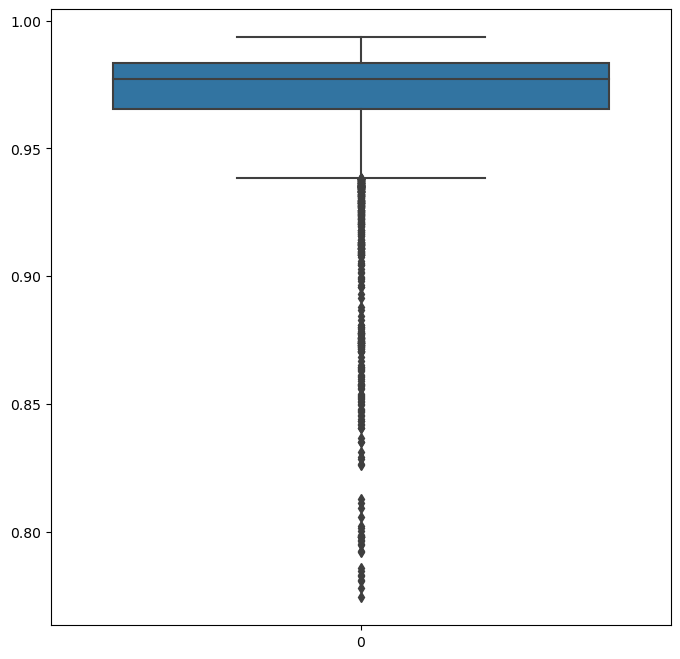

In [87]:
plt.figure(figsize = (8,8))
sns.boxplot(minmax_corr['avg'])
plt.show()

In [88]:
covid_data_5 = df[[f"feature{i*5}" for i in range(int(len(df.columns)/5))]]

In [89]:
minmax_corr2 = pd.DataFrame(columns = ['firstcol','lastcol','min','avg','max'])
for i in range(int(len(covid_data_5.columns)/5)):
  corr_all_matrix = covid_data_5.iloc[:,5*i:min(5*(i+1),len(covid_data_5.columns))].select_dtypes(include = "number").corr()
  corr_all_df = corr_all_matrix.stack().reset_index()
  corr_all_df.columns = ['v1', 'v2', 'correlation']
  minmax_corr2.loc[len(minmax_corr2)] = [covid_data_5.columns[5*i],covid_data_5.columns[min(5*(i+1),len(covid_data_5.columns)-1)],min(corr_all_df.correlation.abs()),mean(corr_all_df.correlation.abs()),max(corr_all_df.correlation.abs())]
print(minmax_corr2)

          firstcol       lastcol       min       avg  max
0         feature0     feature25  0.584655  0.796792  1.0
1        feature25     feature50  0.780590  0.906164  1.0
2        feature50     feature75  0.883784  0.951339  1.0
3        feature75    feature100  0.847422  0.937222  1.0
4       feature100    feature125  0.861473  0.934422  1.0
...            ...           ...       ...       ...  ...
2616  feature65400  feature65425  0.906182  0.944989  1.0
2617  feature65425  feature65450  0.836949  0.931270  1.0
2618  feature65450  feature65475  0.845772  0.937411  1.0
2619  feature65475  feature65500  0.818075  0.934288  1.0
2620  feature65500  feature65525  0.707450  0.856393  1.0

[2621 rows x 5 columns]


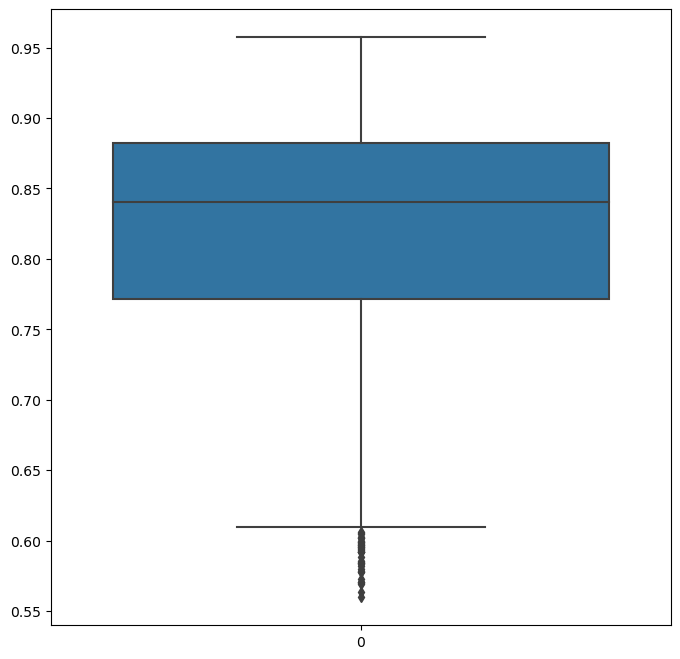

In [90]:
plt.figure(figsize = (8,8))
sns.boxplot(minmax_corr2['avg'])
plt.show()

In [91]:
covid_data_25 = df[[f"feature{i*25}" for i in range(int(len(df.columns)/25))]]

In [93]:
minmax_corr3 = pd.DataFrame(columns = ['firstcol','lastcol','min','avg','max'])
for i in range(int(len(covid_data_25.columns)/5)):
  corr_all_matrix = covid_data_25.iloc[:,5*i:min(5*(i+1),len(covid_data_25.columns))].select_dtypes(include = "number").corr()
  corr_all_df = corr_all_matrix.stack().reset_index()
  corr_all_df.columns = ['v1', 'v2', 'correlation']
  minmax_corr3.loc[len(minmax_corr3)] = [covid_data_25.columns[5*i],covid_data_25.columns[min(5*(i+1),len(covid_data_25.columns))],min(corr_all_df.correlation.abs()),mean(corr_all_df.correlation.abs()),max(corr_all_df.correlation.abs())]
print(minmax_corr3)

         firstcol       lastcol       min       avg  max
0        feature0    feature125  0.206202  0.655821  1.0
1      feature125    feature250  0.579938  0.784276  1.0
2      feature250    feature375  0.269322  0.660076  1.0
3      feature375    feature500  0.632474  0.797846  1.0
4      feature500    feature625  0.395488  0.671021  1.0
..            ...           ...       ...       ...  ...
519  feature64875  feature65000  0.666118  0.818158  1.0
520  feature65000  feature65125  0.224020  0.637980  1.0
521  feature65125  feature65250  0.697740  0.830043  1.0
522  feature65250  feature65375  0.278064  0.663257  1.0
523  feature65375  feature65500  0.696786  0.833121  1.0

[524 rows x 5 columns]


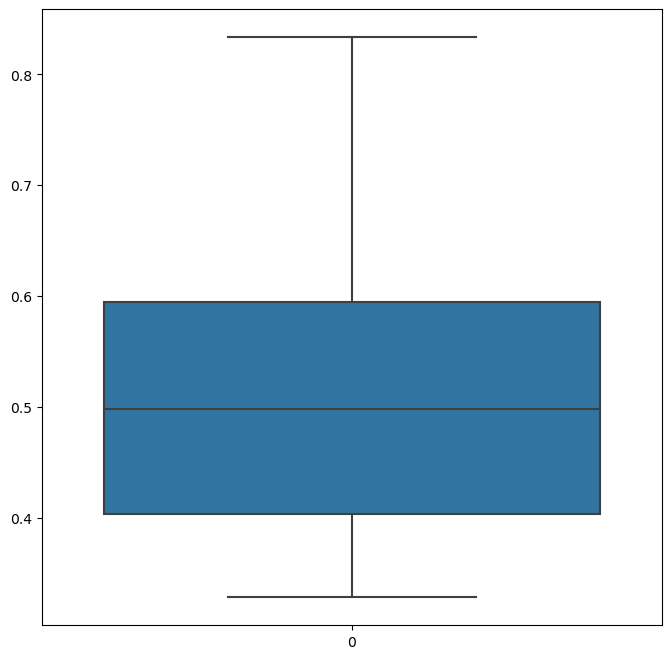

In [81]:
plt.figure(figsize = (8,8))
sns.boxplot(minmax_corr3['avg'])
plt.show()

In [95]:

features=[col for col in df.columns if col.startswith('feature')]
X_train=df[features]
X_test=df_test[features]
X_test_out=df_test_out[features]
y_train=df['binary_label']
y_test=df_test['binary_label']
y_test_out=df_test_out['binary_label']

## 2.2 Hyperparameters:

models were tuned in other jupyter notebook files, the hyperparameters for lr, dt, rf, xgb, svm models are as bellow:

<img src="picture2.png" alt="My Image" width="600"/>

## 2.3 Fine tuned lr, dt, rf, xgb, svm models:

In [83]:
# .pkl model need to use version 1.2.2 to unpacking
# If the belowing pkl file faied to loading, run this code: 
# !pip install scikit-learn==1.2.2

In [96]:
# Load the lr, dt, rf, xgb, svm models
best_lr = LogisticRegression(random_state=42,max_iter= 2000, C=0.001)
best_lr.fit(X_train, y_train)

best_dt = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=10, max_features='sqrt', min_samples_leaf=1, min_samples_split=10)
best_dt.fit(X_train, y_train)

best_rf = RandomForestClassifier(random_state=42, n_estimators= 100, max_depth=10)
best_rf.fit(X_train, y_train)


best_xgb = XGBClassifier(objective='binary:logistic', n_estimators=50, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, nthread=4, seed=42)
best_xgb.fit(X_train, y_train)

best_svm = SVC(random_state= 42, C=10, gamma=0.0001, kernel='rbf')
best_svm.fit(X_train, y_train)

SVC(C=10, gamma=0.0001, random_state=42)

## 2.3.1 Evaluation on test set

In [97]:

best_model_dict_2 = {'Name':[],
                     'Accuracy': [],
                     'Precision': [],
                     'Recall': [],
                     'F1_score': []}

# best lr
accuracy, recall, precision, f1 = get_score(best_lr, X_test, y_test)
add_to_dict(best_model_dict_2, 'Logistic Regression', accuracy, precision, recall, f1)

# best dt
accuracy, recall, precision, f1 = get_score(best_dt, X_test, y_test)
add_to_dict(best_model_dict_2, 'Decision Tree', accuracy, precision, recall, f1)

# best rf
accuracy, recall, precision, f1 = get_score(best_rf, X_test, y_test)
add_to_dict(best_model_dict_2, 'Random Forest', accuracy, precision, recall, f1)


# best xgb
accuracy, recall, precision, f1 = get_score(best_xgb, X_test, y_test)
add_to_dict(best_model_dict_2, 'XGBoost', accuracy, precision, recall, f1)

# best svm rbf
accuracy, recall, precision, f1 = get_score(best_svm, X_test, y_test)
add_to_dict(best_model_dict_2, 'Supper Vector Machine', accuracy, precision, recall, f1)

results_2 = pd.DataFrame(best_model_dict_2)
results_2
#results_2.to_csv('result_augument_data_1.csv', index=False)

Name  Accuracy  Precision    Recall  F1_score
0    Logistic Regression  0.920354   0.883721  0.904762  0.894118
1          Decision Tree  0.849558   0.820513  0.761905  0.790123
2          Random Forest  0.938053   0.948718  0.880952  0.913580
3                XGBoost  0.964602   0.975000  0.928571  0.951220
4  Supper Vector Machine  0.946903   0.973684  0.880952  0.925000

## 2.3.1 Evaluation on outside test set

In [98]:
best_model_dict_3 = {'Name':[],
                     'Accuracy': [],
                     'Precision': [],
                     'Recall': [],
                     'F1_score': []}

# best lr
accuracy, recall, precision, f1 = get_score(best_lr, X_test_out, y_test_out)
add_to_dict(best_model_dict_3, 'Logistic Regression', accuracy, precision, recall, f1)

# best dt
accuracy, recall, precision, f1 = get_score(best_dt, X_test_out, y_test_out)
add_to_dict(best_model_dict_3, 'Decision Tree', accuracy, precision, recall, f1)

# best rf
accuracy, recall, precision, f1 = get_score(best_rf, X_test_out, y_test_out)
add_to_dict(best_model_dict_3, 'Random Forest_1', accuracy, precision, recall, f1)


# best xgb
accuracy, recall, precision, f1 = get_score(best_xgb, X_test_out, y_test_out)
add_to_dict(best_model_dict_3, 'XGBoost', accuracy, precision, recall, f1)

# best svm rbf
accuracy, recall, precision, f1 = get_score(best_svm, X_test_out, y_test_out)
add_to_dict(best_model_dict_3, 'Supper Vector Machine', accuracy, precision, recall, f1)

results_3 = pd.DataFrame(best_model_dict_3)
results_3

# results_3.to_csv('result_outside_test_data.csv', index=False)

Name  Accuracy  Precision    Recall  F1_score
0    Logistic Regression  0.690888   0.624000  0.795918  0.699552
1          Decision Tree  0.615917   0.575835  0.571429  0.573624
2        Random Forest_1  0.692042   0.628866  0.778061  0.695553
3                XGBoost  0.671280   0.615551  0.727041  0.666667
4  Supper Vector Machine  0.690888   0.609155  0.882653  0.720833

Random Forest_1 and super vector machine rbf model were chosen since they performance better on both inside and outside test data.

In [99]:
import tensorflow as tf
def print_confusion_matrix(y_actual,preds=None,probabilities=None,title="",pred_proba=0.5):
    if probabilities is not None:
        preds=[(prob>pred_proba).astype(int) for prob in probabilities]
    conf_mat=tf.math.confusion_matrix(y_actual, preds)
    true_negatives = conf_mat[0, 0]
    false_positives = conf_mat[0, 1]
    false_negatives = conf_mat[1, 0]
    true_positives = conf_mat[1, 1]
    print(f'\nConfusion Matrix {title}')
    print(f"\tTrue Negatives: {true_negatives}\n\tFalse Positives: {false_positives}\n\tFalse Negatives: {false_negatives}\n\tTrue Positive: {true_positives}")

# 2.4 Baseline Neural Network

In [100]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
model_nn = Sequential([
  Dense(units=64, activation='relu'),  # Input layer with feature size
  Dense(units=32, activation='relu'),
  Dense(units=1, activation='sigmoid')])

In [101]:
from tensorflow.keras import optimizers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# Compile the model
model_nn.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy','recall'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)
model_nn.fit(X_train, y_train, epochs=15, batch_size=128, validation_split = 0.15,callbacks=[early_stopping])

Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - accuracy: 0.6522 - loss: 5.0007 - recall: 0.2548 - val_accuracy: 0.6985 - val_loss: 4.1900 - val_recall: 0.0000e+00
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6376 - loss: 3.0982 - recall: 0.2060 - val_accuracy: 0.6985 - val_loss: 1.4717 - val_recall: 0.0000e+00
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6872 - loss: 1.1669 - recall: 0.2346 - val_accuracy: 0.6985 - val_loss: 0.6488 - val_recall: 0.0000e+00
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7373 - loss: 0.5925 - recall: 0.2807 - val_accuracy: 0.8162 - val_loss: 0.3378 - val_recall: 0.4634
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8270 - loss: 0.3740 - recall: 0.5332 - val_accuracy: 0.8971 - val_loss: 0.2659 - val_recall: 0.8049
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8806 - loss: 0.2877 - recall: 0.7386 - val_accuracy: 0.9265 - val_loss: 0.2549 - val_recall: 0.9268
Epoch 7/1

In [102]:
pred_probs=model_nn.predict(X_test) #Obtain probabilities for each test image

test_loss, test_accuracy,test_recall = model_nn.evaluate(X_test, y_test)
print("Neural Network Test Accuracy", test_accuracy)
print("Neural Network Test Recall",test_recall)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8992 - loss: 0.2562 - recall: 0.9223 
Neural Network Test Accuracy 0.8938053250312805
Neural Network Test Recall 0.8809523582458496


In [103]:
print_confusion_matrix(y_test, probabilities=pred_probs.reshape(-1,), title='Neural Network')


Confusion Matrix Neural Network
	True Negatives: 64
	False Positives: 7
	False Negatives: 5
	True Positive: 37


## 2.5 Tuned Neural Network

## 2.5.1 Model trainning

In [104]:
X_train_removed_array = X_train.to_numpy()
X_train_3D = X_train_removed_array.reshape(X_train.shape[0],256,256)
X_test_removed_array = X_test.to_numpy()
X_test_3D = X_test_removed_array.reshape(X_test.shape[0],256,256)

In [105]:
#Create callback to save the weights after each epoch
class customCallback(callbacks.Callback):
  def on_train_begin(self,logs=None):
    self.model.all_weights = []
  def on_epoch_end(self,epoch,logs=None):
    self.weight_list = []
    for layer in self.model.layers:
      if layer.get_weights() == []:
        self.weight_list += [np.nan]
      else:
        self.weight_list += [np.mean(layer.get_weights()[0])]
    self.model.all_weights += [self.weight_list]

In [106]:
from keras import layers, models, utils
@utils.register_keras_serializable(package="my_package", name="add_layer")
# @keras.utils.register_keras_serializable(package="my_package", name="add_layer")
def add_layer(model,num_layer,neurons):
  for i in range(num_layer):
    model.add(Dense(neurons,activation='relu'))

In [107]:
@utils.register_keras_serializable(package="my_package", name="add_layer_lr")
#@keras.utils.register_keras_serializable(package="my_package", name="add_layer_lr")
def add_layer_lr(model,num_layer,neurons,slope):
  act = tf.keras.layers.LeakyReLU(negative_slope=slope)
  for i in range(num_layer):
    model.add(Dense(neurons,activation=act))

In [96]:
#!pip install --upgrade tensorflow keras


In [97]:
def create_nn_5_128(input_shape):
    model = Sequential() # Creates instance of Sequential model, model for NN where layers are added up in sequence (One input tensor and one output tensor)
    model.add(Conv2D(filters=100, kernel_size=5, activation='relu', input_shape=input_shape)) # 1D convolutional layer to model, 64 neurons, each filter extracts different features from input data
    # Kernel size 3, each filter covers 3 units in the input dimension. Relu, allows the model to capture non-linear relationships
    model.add(MaxPooling2D(pool_size=2)) # Layer reduces the dimensionality of the data by taking the max value over a window of 2 units along each feature dimension
    # Makes the model more efficient and less sensitive to small variation in the position of features
    model.add(Flatten()) # Adds flatten layer, converts multidimensional output of previous layers into a 1D array for fully connected layer
    model.add(Dense(128, activation='relu')) # Adds dense layer (fully connected), 50 neurons and again uses relu activation
    add_layer(model,5,128)
    model.add(Dense(64, activation='relu')) # Adds dense layer (fully connected), 50 neurons and again uses relu activation
    model.add(Dense(32, activation='relu')) # Adds dense layer (fully connected), 50 neurons and again uses relu activation
    model.add(Dense(1, activation='sigmoid'))  # Adds another dense layer, 1 unit for output layer, single neuron whose task is regression. Activation is linear for regression
    opt = tf.keras.optimizers.Adam(learning_rate=0.005, beta_1=0.999, beta_2=0.999)
    f1_score = tf.keras.metrics.F1Score(threshold=0.5)
    precision = tf.keras.metrics.Precision(thresholds=0.5)
    recall = tf.keras.metrics.Recall(thresholds=0.5)
    model.compile(optimizer=opt, loss=BinaryCrossentropy(), metrics=['accuracy',f1_score,precision,recall]) # Compiles the model, uses Adam optimizer which combines the advantages of Adaptive Gradient Algorithm and Root Mean Square Propagation
    # Uses MSE as loss function, typical for regression task
    return model

input_shape = (256,256,1)  # 12 features, 1 row per input
nn_model_5_128 = create_nn_5_128(input_shape)
nn_model_5_128.summary()

/Users/bcsstaff/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 252, 252, 100)  │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 126, 100)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1587600)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 128)            │   203,212,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,308,457 (775.56 MB)

 Trainable params: 203,308,457 (775.56 MB)

 Non-trainable params: 0 (0.00 B)

In [109]:
#attempt to fix
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

def create_nn_new(input_shape):
    model = Sequential()
    model.add(Conv2D(filters=100, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.005, beta_1=0.999, beta_2=0.999)
    f1_score = tf.keras.metrics.F1Score(threshold=0.5)
    precision = tf.keras.metrics.Precision(thresholds=0.5)
    recall = tf.keras.metrics.Recall(thresholds=0.5)
    
    model.compile(optimizer=opt, loss=BinaryCrossentropy(), 
                  metrics=['accuracy', f1_score, precision, recall])
    return model

input_shape = (256, 256, 1)
nn_model_new = create_nn_new(input_shape)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Verbosity mode
    mode='min',          # Mode: 'min' for val_loss, 'max' for val_accuracy
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)
rerun=False
if rerun:
    model_new_history = nn_model_new.fit(X_train_3D, y_train, epochs=15, batch_size=32, 
                                      callbacks=[customCallback(), early_stopping], 
                                      validation_split=0.15)
    pickle.dump(nn_model_new, open('neural_net_covid_v_all_2.pkl','wb'))
else:
    nn_model_new = pickle.load(open('neural_net_covid_v_all_2.pkl','rb'))


In [114]:
pred_probs_tuned=nn_model_new.predict(X_test_3D) #Obtain probabilities for each test image
test_loss_tuned, test_accuracy_tuned, test_f1_score_tuned, test_precision_tuned, test_recall_tuned = nn_model_new.evaluate(X_test_3D, y_test)
print("Tuned Neural Network Test Accuracy", test_accuracy_tuned)
print("Tuned Neural Network Test F1 Score",test_f1_score_tuned)
print("Tuned Neural Network Test Precision", test_precision_tuned)
print("Tuned Neural Network Test Recall",test_recall_tuned)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 425ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 426ms/step - accuracy: 0.9315 - f1_score: 0.9117 - loss: 0.2646 - precision_1: 1.0000 - recall_14: 0.8381
Tuned Neural Network Test Accuracy 0.9380530714988708
Tuned Neural Network Test F1 Score 0.9090908765792847
Tuned Neural Network Test Precision 1.0
Tuned Neural Network Test Recall 0.8333333134651184


## 2.5.2 Evaluation on test set

In [101]:
pred_probs_tuned=nn_model_5_128.predict(X_test_3D) #Obtain probabilities for each test image
test_loss_tuned, test_accuracy_tuned, test_f1_score_tuned, test_precision_tuned, test_recall_tuned = nn_model_5_128.evaluate(X_test_3D, y_test)
print("Tuned Neural Network Test Accuracy", test_accuracy_tuned)
print("Tuned Neural Network Test F1 Score",test_f1_score_tuned)
print("Tuned Neural Network Test Precision", test_precision_tuned)
print("Tuned Neural Network Test Recall",test_recall_tuned)

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x19740a660> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 532ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 370ms/step - accuracy: 0.9377 - f1_score: 0.9247 - loss: 0.3412 - precision: 0.9356 - recall_13: 0.9143
Tuned Neural Network Test Accuracy 0.9380530714988708
Tuned Neural Netw

## 2.5.3 Evaluation on outside test set

In [115]:
X_test_out_removed_array = X_test_out.to_numpy()
X_test_out_3D = X_test_out_removed_array.reshape(X_test_out.shape[0],256,256)

In [116]:
pred_probs_tuned=nn_model_new.predict(X_test_out_3D) #Obtain probabilities for each test image
test_out_loss_tuned, test_out_accuracy_tuned, test_out_f1_score_tuned, test_out_precision_tuned, test_out_recall_tuned = nn_model_new.evaluate(X_test_out_3D, y_test_out)
print("Tuned Neural Network Test Accuracy", test_out_accuracy_tuned)
print("Tuned Neural Network Test F1 Score",test_out_f1_score_tuned)
print("Tuned Neural Network Test Precision", test_out_precision_tuned)
print("Tuned Neural Network Test Recall",test_out_recall_tuned)

28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 494ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 628ms/step - accuracy: 0.7299 - f1_score: 0.7930 - loss: 1.0741 - precision_1: 0.9165 - recall_14: 0.7054
Tuned Neural Network Test Accuracy 0.7047289609909058
Tuned Neural Network Test F1 Score 0.6847289800643921
Tuned Neural Network Test Precision 0.6619047522544861
Tuned Neural Network Test Recall 0.7091836929321289


# Final Model: Support Vector Machine RBF, C=0.5

**The value of C was adjusted to help reduce the affect of single data points and make the data generalize better to the outside test set.  The value was set at a low value which created a wider margin, allowing more misclassifications but ultimately resulted in a better f1 score in both the small and large test sets**

In [130]:
train_df=pd.read_csv('covid_data_augmented_train.csv')
train_df=train_df.drop(columns=removed_features)

test_df=pd.read_csv('covid_data_test.csv')
test_df=test_df.drop(columns=removed_features)
test_df_out=pd.read_csv('Outside_Test_Set_Cropped_Reduced_Augmented.csv')
print('*'*15+'Final Model Results'+'*'*15)
svm_mod=SVC(C=.5,max_iter=1200)



features = [col for col in train_df.columns if col.startswith('feature')]
X_train = train_df[features].values
y_train = train_df['binary_label']
X_test=test_df[features].values
y_test=test_df['binary_label']

X_test_out=test_df_out[features].values
y_test_out=test_df_out['binary_label']

scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)
X_test_out_scaled=scaler.transform(X_test_out)

svm_mod.fit(X_train_scaled,y_train)

y_pred_test = svm_mod.predict(X_test_scaled)
# Calculate and print metrics for the test set
print("Test Set Metrics:")
print(f"F1 Score: {f1_score(y_test, y_pred_test):.4f}")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precision Score: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall Score: {recall_score(y_test, y_pred_test):.4f}")
print()

# Make predictions on the out-of-sample test set
y_pred_test_out = svm_mod.predict(X_test_out_scaled)

# Calculate and print metrics for the out-of-sample test set
print("Outside test set Test Set Metrics:")
print(f"F1 Score: {f1_score(y_test_out, y_pred_test_out):.4f}")
print(f"Accuracy Score: {accuracy_score(y_test_out, y_pred_test_out):.4f}")
print(f"Precision Score: {precision_score(y_test_out, y_pred_test_out):.4f}")
print(f"Recall Score: {recall_score(y_test_out, y_pred_test_out):.4f}")
print('\nSmall Test Set')
CPF.print_confusion_matrix(y_test,y_pred_test)
print('\nOutside Test Set')
CPF.print_confusion_matrix(y_test_out,y_pred_test_out)

***************Final Model Results***************
Test Set Metrics:
F1 Score: 0.9383
Accuracy Score: 0.9558
Precision Score: 0.9744
Recall Score: 0.9048

Outside test set Test Set Metrics:
F1 Score: 0.7505
Accuracy Score: 0.7209
Precision Score: 0.6298
Recall Score: 0.9286

Small Test Set

Confusion Matrix 
	True Negatives: 70
	False Positives: 1
	False Negatives: 4
	True Positive: 38

Outside Test Set

Confusion Matrix 
	True Negatives: 261
	False Positives: 214
	False Negatives: 28
	True Positive: 364


# Next Steps
# 3. Future Opportunities: [1: Covid + Pneumonia; 0: normal]
## Regroup data with all Covid and Pneumonia records in the positive class and all normal records in the negative class
### Goal: Create model to distinguish between sick and healthy lungs

## 3.1 Relabel the target

In [118]:
binary_label = []
for i in range(len(df)):
  if df.loc[i]['label'] == 2:
    binary_label += [0]
  else:
    binary_label += [1]
df['binary_label'] = binary_label

binary_label = []
for i in range(len(df_test)):
  if df_test.loc[i]['label'] == 2:
    binary_label += [0]
  else:
    binary_label += [1]
df_test['binary_label'] = binary_label

binary_label = []
for i in range(len(df_test_out)):
  if df_test_out.loc[i]['label'] == 2:
    binary_label += [0]
  else:
    binary_label += [1]
df_test_out['binary_label'] = binary_label

## 3.2 Exploratory Data Analysis

In [119]:
df['feature0'].groupby(df['binary_label']).count()

binary_label
0    382
1    522
Name: feature0, dtype: int64

In [120]:
features=[col for col in df.columns if col not in ['index','Unnamed: 0','label','binary_label','Image_Path']]
X_train=df[features]
X_test=df_test[features]
X_test_out=df_test_out[features]
y_train=df['binary_label']
y_test=df_test['binary_label']
y_test_out=df_test_out['binary_label']

In [121]:
X_train.shape

(904, 65536)

## 3.3 Hyperparameters:

models were tuned in other jupyter notebook files, the hyperparameters for lr, dt, rf, xgb, svm models are as bellow:

<img src="picture3.png" alt="My Image" width="600"/>

## 3.4 Fine tuned lr, dt, rf, xgb, svm models:

In [122]:
# Load the models
best_lr = LogisticRegression(random_state=42, C = 0.01, solver = 'liblinear', max_iter=2000)
best_lr.fit(X_train, y_train)

best_dt = DecisionTreeClassifier(random_state=42, criterion= 'entropy', max_depth=10,max_features='sqrt', min_samples_leaf=1, min_samples_split= 2)
best_dt.fit(X_train, y_train)

best_rf = RandomForestClassifier(random_state=42)
best_rf .fit(X_train, y_train)

best_xgb = XGBClassifier(objective='binary:logistic', n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, nthread=4, seed=42)
best_xgb.fit(X_train, y_train)
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
best_svm = SVC(random_state= 42, C=10, gamma=0.001, kernel='rbf')
best_svm.fit(X_train_scaled, y_train)

SVC(C=10, gamma=0.001, random_state=42)

## 3.4.1 Evaluation on test set

In [127]:
best_model_dict_4 = {'Name':[],
             'Accuracy': [],
             'Precision': [],
             'Recall': [],
             'F1_score': []}

# best lr 
accuracy, recall, precision, f1 = get_score(best_lr, X_test, y_test)
add_to_dict(best_model_dict_4, 'Logistic Regression', accuracy, precision, recall, f1)

# best dt
accuracy, recall, precision, f1 = get_score(best_dt, X_test, y_test)
add_to_dict(best_model_dict_4, 'Decision Tree', accuracy, precision, recall, f1)

# best rf
accuracy, recall, precision, f1 = get_score(best_rf, X_test, y_test)
add_to_dict(best_model_dict_4, 'Random Forest', accuracy, precision, recall, f1)

# best xgb
accuracy, recall, precision, f1 = get_score(best_xgb, X_test, y_test)
add_to_dict(best_model_dict_4, 'Xgboost', accuracy, precision, recall, f1)

# best_svm rbf
accuracy, recall, precision, f1 = get_score(best_svm, X_test, y_test)
add_to_dict(best_model_dict_4, 'Supper Vector Machine: rbf', accuracy, precision, recall, f1)

# best_svm linear
#accuracy, recall, precision, f1 = get_score(best_svm_linear, X_test, y_test)
add_to_dict(best_model_dict_4, 'Supper Vector Machine: linear', accuracy, precision, recall, f1)

# print results
results_4 = pd.DataFrame(best_model_dict_4)
results_4

#results_4.to_csv('result_augument_data_2.csv', index=False)

Name  Accuracy  Precision    Recall  F1_score
0            Logistic Regression  0.840708   0.842105  0.914286  0.876712
1                  Decision Tree  0.769912   0.823529  0.800000  0.811594
2                  Random Forest  0.814159   0.835616  0.871429  0.853147
3                        Xgboost  0.867257   0.866667  0.928571  0.896552
4     Supper Vector Machine: rbf  0.867257   0.910448  0.871429  0.890511
5  Supper Vector Machine: linear  0.867257   0.910448  0.871429  0.890511

## 3.4.2 Evaluation on outside test set

In [129]:
best_model_dict_5 = {'Name':[],
             'Accuracy': [],
             'Precision': [],
             'Recall': [],
             'F1_score': []}

# best lr 
accuracy, recall, precision, f1 = get_score(best_lr, X_test_out, y_test_out)
add_to_dict(best_model_dict_5, 'Logistic Regression', accuracy, precision, recall, f1)

# best dt
accuracy, recall, precision, f1 = get_score(best_dt, X_test_out, y_test_out)
add_to_dict(best_model_dict_5, 'Decision Tree', accuracy, precision, recall, f1)

# best rf
accuracy, recall, precision, f1 = get_score(best_rf, X_test_out, y_test_out)
add_to_dict(best_model_dict_5, 'Random Forest', accuracy, precision, recall, f1)

# best xgb
accuracy, recall, precision, f1 = get_score(best_xgb, X_test_out, y_test_out)
add_to_dict(best_model_dict_5, 'Xgboost', accuracy, precision, recall, f1)

# best_svm rbf
accuracy, recall, precision, f1 = get_score(best_svm, X_test_out, y_test_out)
add_to_dict(best_model_dict_5, 'Supper Vector Machine: rbf', accuracy, precision, recall, f1)

# best_svm linear
#accuracy, recall, precision, f1 = get_score(best_svm_linear, X_test_out, y_test_out)
#add_to_dict(best_model_dict_5, 'Supper Vector Machine: linear', accuracy, precision, recall, f1)

# print results
results_5 = pd.DataFrame(best_model_dict_5)
results_5

#results_5.to_csv('result_augument_data_2_out.csv', index=False)

Name  Accuracy  Precision    Recall  F1_score
0         Logistic Regression  0.686275   0.742025  0.861514  0.797317
1               Decision Tree  0.637832   0.727407  0.790660  0.757716
2               Random Forest  0.701269   0.737533  0.904992  0.812726
3                     Xgboost  0.686275   0.731126  0.888889  0.802326
4  Supper Vector Machine: rbf  0.692042   0.738544  0.882448  0.804109

## 3.5 Tuned Neural Network

In [ ]:
X_train_removed_array = X_train.to_numpy()
X_train_3D = X_train_removed_array.reshape(X_train.shape[0],256,256)
X_test_removed_array = X_test.to_numpy()
X_test_3D = X_test_removed_array.reshape((X_test.shape[0],256,-1))


## 3.5.1 Model Trainning

In [ ]:
def create_nn_new(input_shape):
    model = Sequential() # Creates instance of Sequential model, model for NN where layers are added up in sequence (One input tensor and one output tensor)
    model.add(Conv2D(filters=100, kernel_size=5, activation='relu', input_shape=input_shape)) # 1D convolutional layer to model, 64 neurons, each filter extracts different features from input data
    # Kernel size 3, each filter covers 3 units in the input dimension. Relu, allows the model to capture non-linear relationships
    model.add(MaxPooling2D(pool_size=2)) # Layer reduces the dimensionality of the data by taking the max value over a window of 2 units along each feature dimension
    # Makes the model more efficient and less sensitive to small variation in the position of features
    model.add(Flatten()) # Adds flatten layer, converts multidimensional output of previous layers into a 1D array for fully connected layer
    model.add(Dense(128, activation='relu')) # Adds dense layer (fully connected), 50 neurons and again uses relu activation
    add_layer(model,5,128)
    model.add(Dense(64, activation='relu')) # Adds dense layer (fully connected), 50 neurons and again uses relu activation
    model.add(Dense(32, activation='relu')) # Adds dense layer (fully connected), 50 neurons and again uses relu activation
    model.add(Dense(1, activation='sigmoid'))  # Adds another dense layer, 1 unit for output layer, single neuron whose task is regression. Activation is linear for regression
    opt = tf.keras.optimizers.Adam(learning_rate=0.005, beta_1=0.999, beta_2=0.999)
    f1_score = tf.keras.metrics.F1Score(threshold=0.5)
    precision = tf.keras.metrics.Precision(thresholds=0.5)
    recall = tf.keras.metrics.Recall(thresholds=0.5)
    model.compile(optimizer=opt, loss=BinaryCrossentropy(), metrics=['accuracy',f1_score,precision,recall]) # Compiles the model, uses Adam optimizer which combines the advantages of Adaptive Gradient Algorithm and Root Mean Square Propagation
    # Uses MSE as loss function, typical for regression task
    return model

input_shape = (256,256,1)  # 12 features, 1 row per input
nn_model_new = create_nn_new(input_shape)

In [138]:
#Attempt to fix
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
import pickle
def create_nn_new(input_shape):
    model = Sequential()
    model.add(Conv2D(filters=100, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.005, beta_1=0.999, beta_2=0.999)
    f1_score = tf.keras.metrics.F1Score(threshold=0.5)
    precision = tf.keras.metrics.Precision(thresholds=0.5)
    recall = tf.keras.metrics.Recall(thresholds=0.5)
    
    model.compile(optimizer=opt, loss=BinaryCrossentropy(), 
                  metrics=['accuracy', f1_score, precision, recall])
    return model
RERUN=False
if RERUN:
    input_shape = (256, 256, 1)
    nn_model_new = create_nn_new(input_shape)

# Define the EarlyStopping callback
    early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Verbosity mode
    mode='min',          # Mode: 'min' for val_loss, 'max' for val_accuracy
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

    model_new_history = nn_model_new.fit(X_train_3D, y_train, epochs=15, batch_size=32, 
                                      callbacks=[customCallback(), early_stopping], 
                                      validation_split=0.15)
else:
    # Load the model from the pickle file
    with open('neural_net_covid_v_all_2.pkl', 'rb') as file:
        nn_model_new = pickle.load(file)

# Continue with evaluation and DataFrame creation as before...

## 3.5.2 Evaluation on test set

In [ ]:
pred_probs_tuned=nn_model_new.predict(X_test_3D) #Obtain probabilities for each test image
test_loss_tuned, test_accuracy_tuned, test_f1_score_tuned, test_precision_tuned, test_recall_tuned = nn_model_new.evaluate(X_test_3D, y_test)
print("Tuned Neural Network Test Accuracy", test_accuracy_tuned)
print("Tuned Neural Network Test F1 Score",test_f1_score_tuned)
print("Tuned Neural Network Test Precision", test_precision_tuned)
print("Tuned Neural Network Test Recall",test_recall_tuned)

In [149]:
#pickle.dump(nn_model_new, open('neural_net_covid_v_all_2.pkl','wb'))

## 3.5.3 Evaluation on  outside test

In [ ]:
X_test_out_removed_array = X_test_out.to_numpy()
X_test_out_3D = X_test_out_removed_array.reshape((X_test_out.shape[0],256,-1))

In [ ]:
pred_probs_tuned=nn_model_new.predict(X_test_out_3D) #Obtain probabilities for each test image
test_loss_tuned, test_accuracy_tuned, test_f1_score_tuned, test_precision_tuned, test_recall_tuned = nn_model_new.evaluate(X_test_out_3D, y_test_out)
print("Tuned Neural Network Test Accuracy", test_accuracy_tuned)
print("Tuned Neural Network Test F1 Score",test_f1_score_tuned)
print("Tuned Neural Network Test Precision", test_precision_tuned)
print("Tuned Neural Network Test Recall",test_recall_tuned)

In [147]:
test_df=test_df.drop(columns=removed_features,errors='ignore')
y_test_out_two=test_df['binary_label']
X_test_out_two=test_df[features].values
X_test_out_scaled_two=scaler.transform(X_test_out_two)
y_pred_test_out_two=svm_mod.predict(X_test_out_scaled_two)

# Calculate and print metrics for the out-of-sample test set
print("Outside test set two Test Set Metrics:")
print(f"F1 Score: {f1_score(y_test_out_two, y_pred_test_out_two):.4f}")
print(f"Accuracy Score: {accuracy_score(y_test_out_two, y_pred_test_out_two):.4f}")
print(f"Precision Score: {precision_score(y_test_out_two, y_pred_test_out_two):.4f}")
print(f"Recall Score: {recall_score(y_test_out_two, y_pred_test_out_two):.4f}")

print('\nOutside Test Set Two')
CPF.print_confusion_matrix(y_test_out_two,y_pred_test_out_two)

Outside test set two Test Set Metrics:
F1 Score: 0.6893
Accuracy Score: 0.9271
Precision Score: 0.5569
Recall Score: 0.9043

Outside Test Set Two

Confusion Matrix 
	True Negatives: 4353
	False Positives: 331
	False Negatives: 44
	True Positive: 416


5144